# Generative Models
***

**MIPT, Autumn 2022, MSc course**


## Assignment 4

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

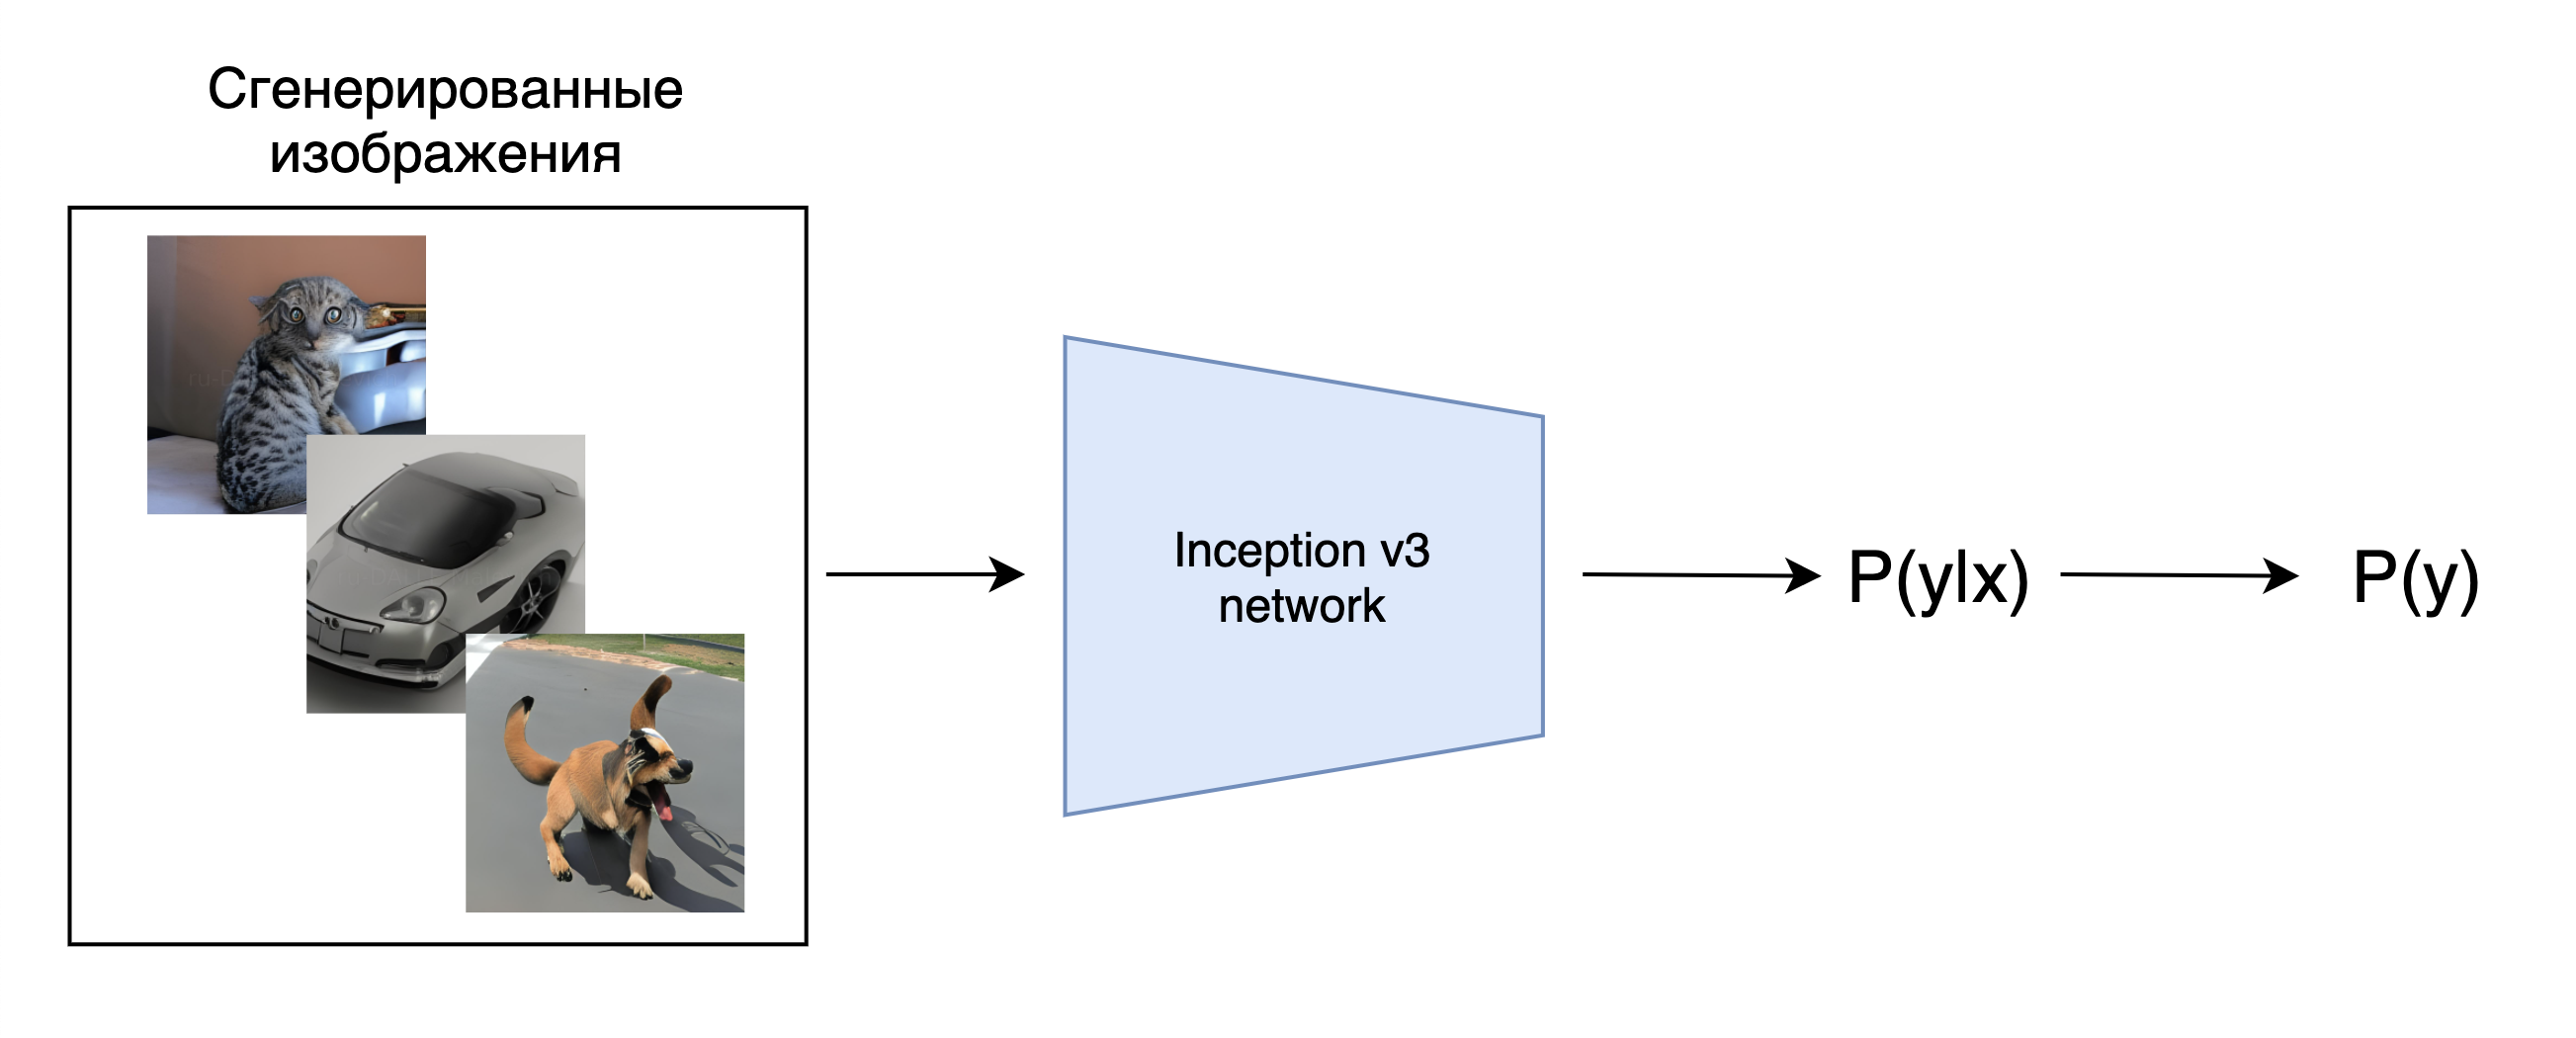

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i 
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx 
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

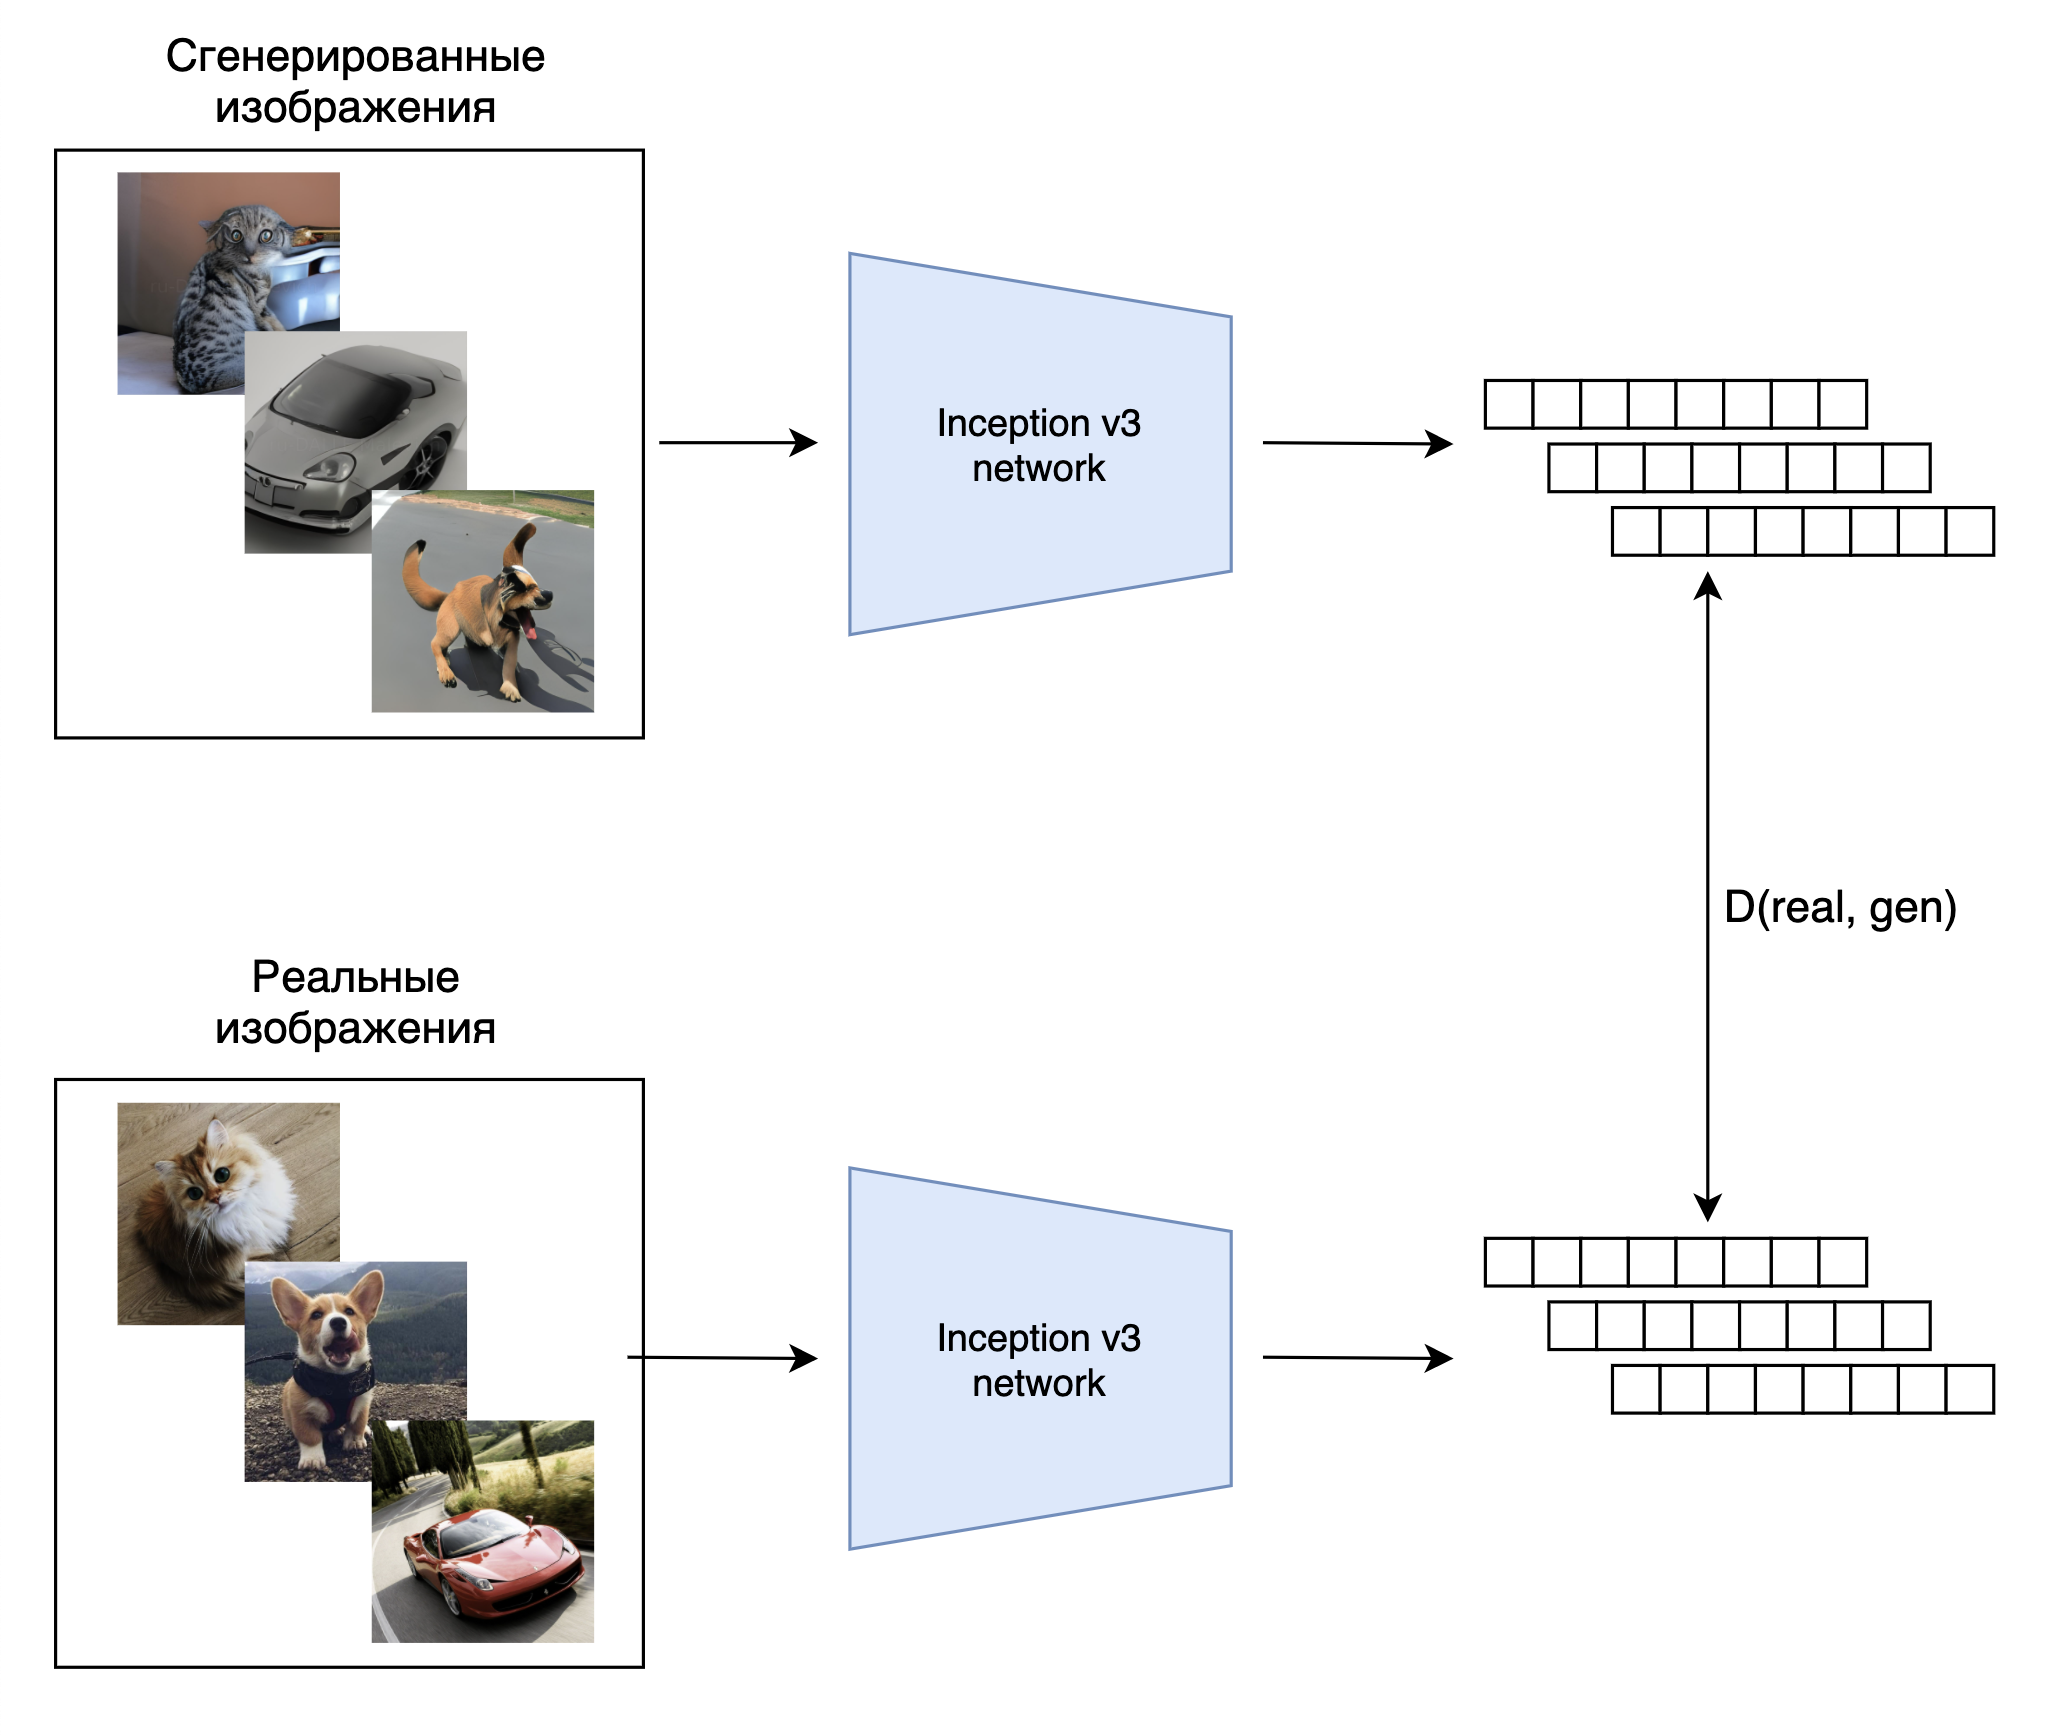

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета. 


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет 

* Обучить GAN на датасете CIFAR10, используя методы регуляризации: label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей без регуляризаций и с различными их комбинациями (хотя бы одной). Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
DCGAN | | 
Label Smoothing (LS) |  | 
Spectral Normalization (SN) |  | 
DCGAN + LS + SN | | 
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset 

In [1]:
import torch 
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image
import os
%matplotlib inline 
plt.style.use("ggplot")

class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images_ls/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  6


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.99215686, -0.860915  , -0.7296732 , -0.59843135, -0.46718955,
        -0.33594772, -0.20470588, -0.07346405,  0.05777778,  0.1890196 ,
         0.32026145,  0.45150328,  0.5827451 ,  0.71398693,  0.84522873,
         0.9764706 ], dtype=float32),
 <a list of 12288 BarContainer objects>)

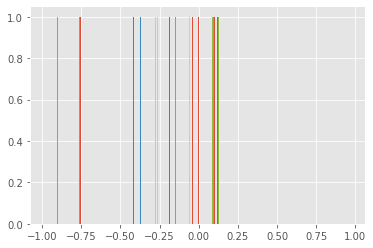

In [3]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

Label:  6


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.00392157, 0.06954248, 0.1351634 , 0.20078431, 0.26640522,
        0.33202615, 0.39764705, 0.46326798, 0.5288889 , 0.5945098 ,
        0.66013074, 0.72575164, 0.79137254, 0.85699344, 0.9226144 ,
        0.9882353 ], dtype=float32),
 <a list of 12288 BarContainer objects>)

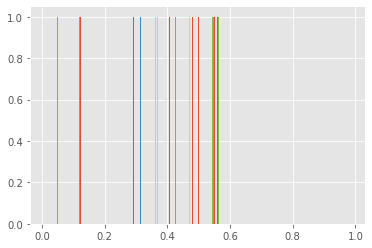

In [5]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    max_pixel_value = 1.
    image = (x + max_pixel_value) / 2
    
    return image

# show  image sample with matplotlib

print("Label: ", label)
plt.hist(denorm(img[:, :, :]).flatten(), bins=15)

In [2]:
def denorm(x):
    max_pixel_value = 1.
    image = (x + max_pixel_value) / 2
    
    return image

In [3]:
# define the dataloader
from torch.utils.data import DataLoader

dataloader = DataLoader(
    cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=8,
    drop_last=True,
    pin_memory=True
)

# Спектральная нормализация

In [4]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks 
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [5]:
import torch.nn as nn
from torch.nn import functional as F
# Generator 
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        # ConvTranspose2d nz ngf * 8
        # BatchNorm2d
        # ReLU
        self.block_1 = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )
        # ConvTranspose2d ngf * 8 ngf * 4
        # BatchNorm2d
        # ReLU
        self.block_2 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        )
        # ConvTranspose2d ngf * 4 ngf * 2
        # BatchNorm2d
        # ReLU
        self.block_3 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )
        # ConvTranspose2d ngf * 2 ngf  
        # BatchNorm2d
        # ReLU
        self.block_4 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )
        # ConvTranspose2d ngf  nc
        self.block_5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        
        # Tanh

    def forward(self, input_):
        x = self.block_1(input_)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        return F.tanh(x)

# Discriminator 

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        # SpectralNorm Conv2d
        # LeakyReLU
        self.block_1 = nn.Sequential(
            nn.Conv2d(nc, ndf, 3, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # SpectralNorm Conv2d
        # BatchNorm2d
        # LeakyReLU
        self.block_2 = nn.Sequential(
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # SpectralNorm Conv2d
        # BatchNorm2d
        # LeakyReLU
        self.block_3 = nn.Sequential(
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # SpectralNorm Conv2d
        # BatchNorm2d
        # LeakyReLU
        self.block_4 = nn.Sequential(
            nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # SpectralNorm Conv2d
        self.block_5 = nn.Conv2d(ndf * 8, 1, 4, 1, 0)
        # Sigmoid
    def forward(self, input_):
        x = self.block_1(input_)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        return F.sigmoid(x)


In [6]:
# create new Generator model

G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)

# create new Discriminator model

D = Discriminator(CFG.nc, CFG.ndf).to(CFG.device)

In [9]:
# feel free to reuse your training functions

Discriminator Training

In [10]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and 
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [11]:

def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optimizer.zero_grad()
    D_optimizer.zero_grad()
  

LABEL_SMOOTH = 0.9
def train_discriminator(images):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = Variable(torch.ones(batch_size, 1).to(device)*LABEL_SMOOTH)
    fake_labels = Variable(torch.ones(batch_size, 1).to(device)*(1- LABEL_SMOOTH))
    
    outputs = D(images)
    # Loss for real images
    real_score = outputs.squeeze().unsqueeze(1)
    # Loss for fake images
    
    z = Variable(torch.randn(batch_size, CFG.nz, 1, 1).to(device))
    fake_images = G(z)
    outputs = D(fake_images)
    fake_score = outputs.squeeze().unsqueeze(1)

    # Sum losses
    real_loss = criterion(real_score, real_labels)
    fake_loss = criterion(fake_score, fake_labels)
    
    d_loss = real_loss + fake_loss

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    D_optimizer.step()
    
    return d_loss, real_score, fake_score

Generator Training

In [12]:
#Add gauss noise
#noise = 0.005*np.random.uniform()*np.amax(sound)

In [13]:
from torch.autograd import Variable

In [19]:
def train_generator():
    # Generate fake images and calculate loss
    #z = torch.randn(batch_size, CFG.nz, 1, 1).to(device)
    z = np.random.normal(0, 1, (batch_size, CFG.nz, 1, 1))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = Variable(torch.Tensor(z).to(device))
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    # calculate the generator loss
    g_loss = criterion(D(fake_images).squeeze().unsqueeze(1), labels)
    
    # Reset gradients
    reset_grad()
    
    # Backprop and optimize
    g_loss.backward()
    
    G_optimizer.step()
    return g_loss, fake_images

## Start the training process

In [20]:
def save_fake_images(index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    z = np.random.normal(0, 1, (batch_size, 100, 1, 1))
    noise = 0.005*np.random.uniform()*np.amax(z)
    z = z.astype('float64') + noise*np.random.normal(size=z.shape)
    z = torch.Tensor(z).to(device)
    fake_images = G(z)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

In [21]:
criterion = nn.BCELoss()

G_optimizer = torch.optim.AdamW(G.parameters(), lr=CFG.lr)
D_optimizer = torch.optim.AdamW(D.parameters(), lr=CFG.lr)

In [22]:
from tqdm import tqdm

In [23]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

total_step = len(dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in tqdm(range(num_epochs)):
    for i, (images, _) in enumerate(dataloader):
        # Load a batch & transform to vectors
        #images = images.reshape(batch_size, -1).to(device)
        images = Variable(images.to(device))
        
        # Train the discriminator
        if (i + 1) % 2 == 0:
            d_loss, real_score, fake_score = train_discriminator(images)
        # Train the generator
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0/300], Step [200/390], d_loss: 0.7659, g_loss: 4.6552, D(x): 0.79, D(G(z)): 0.17


  0%|          | 1/300 [00:25<2:05:19, 25.15s/it]

Saving fake_images-0001.png
Epoch [1/300], Step [200/390], d_loss: 1.1031, g_loss: 2.0354, D(x): 0.62, D(G(z)): 0.34


  1%|          | 2/300 [00:50<2:05:22, 25.24s/it]

Saving fake_images-0002.png
Epoch [2/300], Step [200/390], d_loss: 0.9603, g_loss: 2.2933, D(x): 0.71, D(G(z)): 0.21


  1%|          | 3/300 [01:16<2:05:50, 25.42s/it]

Saving fake_images-0003.png
Epoch [3/300], Step [200/390], d_loss: 1.7571, g_loss: 1.8179, D(x): 0.56, D(G(z)): 0.53


  1%|▏         | 4/300 [01:41<2:05:36, 25.46s/it]

Saving fake_images-0004.png
Epoch [4/300], Step [200/390], d_loss: 0.9708, g_loss: 2.0663, D(x): 0.69, D(G(z)): 0.25


  2%|▏         | 5/300 [02:07<2:05:18, 25.49s/it]

Saving fake_images-0005.png
Epoch [5/300], Step [200/390], d_loss: 0.8951, g_loss: 2.1592, D(x): 0.80, D(G(z)): 0.24


  2%|▏         | 6/300 [02:32<2:04:58, 25.50s/it]

Saving fake_images-0006.png
Epoch [6/300], Step [200/390], d_loss: 1.1336, g_loss: 1.4384, D(x): 0.65, D(G(z)): 0.32


  2%|▏         | 7/300 [02:58<2:04:33, 25.51s/it]

Saving fake_images-0007.png
Epoch [7/300], Step [200/390], d_loss: 0.7856, g_loss: 2.1761, D(x): 0.89, D(G(z)): 0.24


  3%|▎         | 8/300 [03:23<2:04:07, 25.51s/it]

Saving fake_images-0008.png
Epoch [8/300], Step [200/390], d_loss: 0.8360, g_loss: 2.4267, D(x): 0.82, D(G(z)): 0.23


  3%|▎         | 9/300 [03:49<2:03:42, 25.51s/it]

Saving fake_images-0009.png
Epoch [9/300], Step [200/390], d_loss: 0.8071, g_loss: 1.8162, D(x): 0.83, D(G(z)): 0.24


  3%|▎         | 10/300 [04:14<2:03:10, 25.49s/it]

Saving fake_images-0010.png
Epoch [10/300], Step [200/390], d_loss: 1.0815, g_loss: 1.9182, D(x): 0.63, D(G(z)): 0.23


  4%|▎         | 11/300 [04:40<2:02:38, 25.46s/it]

Saving fake_images-0011.png
Epoch [11/300], Step [200/390], d_loss: 1.1623, g_loss: 1.0598, D(x): 0.54, D(G(z)): 0.29


  4%|▍         | 12/300 [05:05<2:02:07, 25.44s/it]

Saving fake_images-0012.png
Epoch [12/300], Step [200/390], d_loss: 1.0533, g_loss: 1.7650, D(x): 0.64, D(G(z)): 0.30


  4%|▍         | 13/300 [05:30<2:01:37, 25.43s/it]

Saving fake_images-0013.png
Epoch [13/300], Step [200/390], d_loss: 0.9293, g_loss: 1.8724, D(x): 0.74, D(G(z)): 0.28


  5%|▍         | 14/300 [05:56<2:01:11, 25.42s/it]

Saving fake_images-0014.png
Epoch [14/300], Step [200/390], d_loss: 1.0327, g_loss: 1.4739, D(x): 0.78, D(G(z)): 0.40


  5%|▌         | 15/300 [06:21<2:00:39, 25.40s/it]

Saving fake_images-0015.png
Epoch [15/300], Step [200/390], d_loss: 1.0492, g_loss: 1.6978, D(x): 0.65, D(G(z)): 0.33


  5%|▌         | 16/300 [06:46<2:00:11, 25.39s/it]

Saving fake_images-0016.png
Epoch [16/300], Step [200/390], d_loss: 1.0200, g_loss: 1.7603, D(x): 0.73, D(G(z)): 0.28


  6%|▌         | 17/300 [07:12<1:59:42, 25.38s/it]

Saving fake_images-0017.png
Epoch [17/300], Step [200/390], d_loss: 1.0105, g_loss: 1.5197, D(x): 0.69, D(G(z)): 0.34


  6%|▌         | 18/300 [07:37<1:59:16, 25.38s/it]

Saving fake_images-0018.png
Epoch [18/300], Step [200/390], d_loss: 0.8939, g_loss: 1.6718, D(x): 0.73, D(G(z)): 0.28


  6%|▋         | 19/300 [08:03<1:58:48, 25.37s/it]

Saving fake_images-0019.png
Epoch [19/300], Step [200/390], d_loss: 0.9988, g_loss: 1.5211, D(x): 0.64, D(G(z)): 0.28


  7%|▋         | 20/300 [08:28<1:58:21, 25.36s/it]

Saving fake_images-0020.png
Epoch [20/300], Step [200/390], d_loss: 0.8980, g_loss: 2.3284, D(x): 0.72, D(G(z)): 0.23


  7%|▋         | 21/300 [08:53<1:57:54, 25.36s/it]

Saving fake_images-0021.png
Epoch [21/300], Step [200/390], d_loss: 1.0759, g_loss: 1.1133, D(x): 0.69, D(G(z)): 0.39


  7%|▋         | 22/300 [09:19<1:57:27, 25.35s/it]

Saving fake_images-0022.png
Epoch [22/300], Step [200/390], d_loss: 1.5240, g_loss: 1.1746, D(x): 0.49, D(G(z)): 0.43


  8%|▊         | 23/300 [09:44<1:57:01, 25.35s/it]

Saving fake_images-0023.png
Epoch [23/300], Step [200/390], d_loss: 0.9909, g_loss: 1.5501, D(x): 0.70, D(G(z)): 0.27


  8%|▊         | 24/300 [10:09<1:56:34, 25.34s/it]

Saving fake_images-0024.png
Epoch [24/300], Step [200/390], d_loss: 1.1722, g_loss: 1.4635, D(x): 0.62, D(G(z)): 0.35


  8%|▊         | 25/300 [10:35<1:56:10, 25.35s/it]

Saving fake_images-0025.png
Epoch [25/300], Step [200/390], d_loss: 1.3552, g_loss: 1.1308, D(x): 0.74, D(G(z)): 0.56


  9%|▊         | 26/300 [11:00<1:55:42, 25.34s/it]

Saving fake_images-0026.png
Epoch [26/300], Step [200/390], d_loss: 1.0979, g_loss: 1.6761, D(x): 0.60, D(G(z)): 0.28


  9%|▉         | 27/300 [11:25<1:55:19, 25.34s/it]

Saving fake_images-0027.png
Epoch [27/300], Step [200/390], d_loss: 1.1999, g_loss: 1.9603, D(x): 0.72, D(G(z)): 0.42


  9%|▉         | 28/300 [11:51<1:54:54, 25.35s/it]

Saving fake_images-0028.png
Epoch [28/300], Step [200/390], d_loss: 1.0699, g_loss: 1.9294, D(x): 0.64, D(G(z)): 0.31


 10%|▉         | 29/300 [12:16<1:54:29, 25.35s/it]

Saving fake_images-0029.png
Epoch [29/300], Step [200/390], d_loss: 1.0453, g_loss: 1.6150, D(x): 0.62, D(G(z)): 0.23


 10%|█         | 30/300 [12:41<1:54:02, 25.34s/it]

Saving fake_images-0030.png
Epoch [30/300], Step [200/390], d_loss: 1.3069, g_loss: 1.7921, D(x): 0.61, D(G(z)): 0.43


 10%|█         | 31/300 [13:07<1:53:37, 25.34s/it]

Saving fake_images-0031.png
Epoch [31/300], Step [200/390], d_loss: 1.0521, g_loss: 1.3037, D(x): 0.63, D(G(z)): 0.28


 11%|█         | 32/300 [13:32<1:53:13, 25.35s/it]

Saving fake_images-0032.png
Epoch [32/300], Step [200/390], d_loss: 1.1375, g_loss: 1.3515, D(x): 0.75, D(G(z)): 0.45


 11%|█         | 33/300 [13:57<1:52:47, 25.35s/it]

Saving fake_images-0033.png
Epoch [33/300], Step [200/390], d_loss: 1.0991, g_loss: 2.2668, D(x): 0.63, D(G(z)): 0.26


 11%|█▏        | 34/300 [14:23<1:52:21, 25.35s/it]

Saving fake_images-0034.png
Epoch [34/300], Step [200/390], d_loss: 0.9036, g_loss: 1.5990, D(x): 0.75, D(G(z)): 0.29


 12%|█▏        | 35/300 [14:48<1:51:55, 25.34s/it]

Saving fake_images-0035.png
Epoch [35/300], Step [200/390], d_loss: 1.1484, g_loss: 1.5592, D(x): 0.61, D(G(z)): 0.34


 12%|█▏        | 36/300 [15:13<1:51:31, 25.35s/it]

Saving fake_images-0036.png
Epoch [36/300], Step [200/390], d_loss: 1.0968, g_loss: 2.3205, D(x): 0.61, D(G(z)): 0.27


 12%|█▏        | 37/300 [15:39<1:51:07, 25.35s/it]

Saving fake_images-0037.png
Epoch [37/300], Step [200/390], d_loss: 0.8533, g_loss: 1.9499, D(x): 0.82, D(G(z)): 0.27


 13%|█▎        | 38/300 [16:04<1:50:47, 25.37s/it]

Saving fake_images-0038.png
Epoch [38/300], Step [200/390], d_loss: 1.1882, g_loss: 1.2716, D(x): 0.55, D(G(z)): 0.30


 13%|█▎        | 39/300 [16:30<1:50:21, 25.37s/it]

Saving fake_images-0039.png
Epoch [39/300], Step [200/390], d_loss: 1.1273, g_loss: 1.6262, D(x): 0.67, D(G(z)): 0.40


 13%|█▎        | 40/300 [16:55<1:49:58, 25.38s/it]

Saving fake_images-0040.png
Epoch [40/300], Step [200/390], d_loss: 1.1509, g_loss: 1.8204, D(x): 0.56, D(G(z)): 0.31


 14%|█▎        | 41/300 [17:20<1:49:32, 25.38s/it]

Saving fake_images-0041.png
Epoch [41/300], Step [200/390], d_loss: 0.9944, g_loss: 1.5164, D(x): 0.72, D(G(z)): 0.32


 14%|█▍        | 42/300 [17:46<1:49:03, 25.36s/it]

Saving fake_images-0042.png
Epoch [42/300], Step [200/390], d_loss: 1.0629, g_loss: 0.9285, D(x): 0.85, D(G(z)): 0.43


 14%|█▍        | 43/300 [18:11<1:48:37, 25.36s/it]

Saving fake_images-0043.png
Epoch [43/300], Step [200/390], d_loss: 1.0069, g_loss: 1.1269, D(x): 0.77, D(G(z)): 0.38


 15%|█▍        | 44/300 [18:36<1:48:13, 25.36s/it]

Saving fake_images-0044.png
Epoch [44/300], Step [200/390], d_loss: 0.7980, g_loss: 2.4350, D(x): 0.80, D(G(z)): 0.21


 15%|█▌        | 45/300 [19:02<1:47:49, 25.37s/it]

Saving fake_images-0045.png
Epoch [45/300], Step [200/390], d_loss: 1.1049, g_loss: 1.2828, D(x): 0.62, D(G(z)): 0.33


 15%|█▌        | 46/300 [19:27<1:47:27, 25.38s/it]

Saving fake_images-0046.png
Epoch [46/300], Step [200/390], d_loss: 0.9465, g_loss: 1.6942, D(x): 0.69, D(G(z)): 0.26


 16%|█▌        | 47/300 [19:52<1:46:57, 25.36s/it]

Saving fake_images-0047.png
Epoch [47/300], Step [200/390], d_loss: 0.9855, g_loss: 1.5040, D(x): 0.70, D(G(z)): 0.31


 16%|█▌        | 48/300 [20:18<1:46:29, 25.36s/it]

Saving fake_images-0048.png
Epoch [48/300], Step [200/390], d_loss: 1.0514, g_loss: 1.5292, D(x): 0.64, D(G(z)): 0.29


 16%|█▋        | 49/300 [20:43<1:46:06, 25.36s/it]

Saving fake_images-0049.png
Epoch [49/300], Step [200/390], d_loss: 1.0360, g_loss: 1.1903, D(x): 0.69, D(G(z)): 0.33


 17%|█▋        | 50/300 [21:09<1:45:40, 25.36s/it]

Saving fake_images-0050.png
Epoch [50/300], Step [200/390], d_loss: 1.0226, g_loss: 1.6894, D(x): 0.62, D(G(z)): 0.26


 17%|█▋        | 51/300 [21:34<1:45:13, 25.35s/it]

Saving fake_images-0051.png
Epoch [51/300], Step [200/390], d_loss: 0.9856, g_loss: 1.4592, D(x): 0.71, D(G(z)): 0.34


 17%|█▋        | 52/300 [21:59<1:44:46, 25.35s/it]

Saving fake_images-0052.png
Epoch [52/300], Step [200/390], d_loss: 0.9745, g_loss: 1.4443, D(x): 0.69, D(G(z)): 0.29


 18%|█▊        | 53/300 [22:25<1:44:20, 25.35s/it]

Saving fake_images-0053.png
Epoch [53/300], Step [200/390], d_loss: 1.0318, g_loss: 1.1297, D(x): 0.63, D(G(z)): 0.29


 18%|█▊        | 54/300 [22:50<1:43:58, 25.36s/it]

Saving fake_images-0054.png
Epoch [54/300], Step [200/390], d_loss: 1.2415, g_loss: 2.6276, D(x): 0.76, D(G(z)): 0.50


 18%|█▊        | 55/300 [23:15<1:43:32, 25.36s/it]

Saving fake_images-0055.png
Epoch [55/300], Step [200/390], d_loss: 0.9640, g_loss: 1.7681, D(x): 0.76, D(G(z)): 0.33


 19%|█▊        | 56/300 [23:41<1:43:06, 25.36s/it]

Saving fake_images-0056.png
Epoch [56/300], Step [200/390], d_loss: 1.2360, g_loss: 1.1898, D(x): 0.48, D(G(z)): 0.21


 19%|█▉        | 57/300 [24:06<1:42:42, 25.36s/it]

Saving fake_images-0057.png
Epoch [57/300], Step [200/390], d_loss: 1.0346, g_loss: 1.5050, D(x): 0.76, D(G(z)): 0.38


 19%|█▉        | 58/300 [24:31<1:42:14, 25.35s/it]

Saving fake_images-0058.png
Epoch [58/300], Step [200/390], d_loss: 1.0887, g_loss: 1.3193, D(x): 0.76, D(G(z)): 0.43


 20%|█▉        | 59/300 [24:57<1:41:49, 25.35s/it]

Saving fake_images-0059.png
Epoch [59/300], Step [200/390], d_loss: 1.0627, g_loss: 1.1507, D(x): 0.68, D(G(z)): 0.36


 20%|██        | 60/300 [25:22<1:41:27, 25.36s/it]

Saving fake_images-0060.png
Epoch [60/300], Step [200/390], d_loss: 1.1874, g_loss: 1.5319, D(x): 0.71, D(G(z)): 0.47


 20%|██        | 61/300 [25:48<1:41:04, 25.37s/it]

Saving fake_images-0061.png
Epoch [61/300], Step [200/390], d_loss: 1.0903, g_loss: 1.4652, D(x): 0.59, D(G(z)): 0.27


 21%|██        | 62/300 [26:13<1:40:38, 25.37s/it]

Saving fake_images-0062.png
Epoch [62/300], Step [200/390], d_loss: 1.0348, g_loss: 1.6170, D(x): 0.77, D(G(z)): 0.39


 21%|██        | 63/300 [26:38<1:40:13, 25.38s/it]

Saving fake_images-0063.png
Epoch [63/300], Step [200/390], d_loss: 0.8017, g_loss: 2.1124, D(x): 0.78, D(G(z)): 0.19


 21%|██▏       | 64/300 [27:04<1:39:45, 25.36s/it]

Saving fake_images-0064.png
Epoch [64/300], Step [200/390], d_loss: 0.7966, g_loss: 1.7848, D(x): 0.84, D(G(z)): 0.24


 22%|██▏       | 65/300 [27:29<1:39:23, 25.37s/it]

Saving fake_images-0065.png
Epoch [65/300], Step [200/390], d_loss: 0.8070, g_loss: 2.3842, D(x): 0.76, D(G(z)): 0.16


 22%|██▏       | 66/300 [27:54<1:38:57, 25.37s/it]

Saving fake_images-0066.png
Epoch [66/300], Step [200/390], d_loss: 0.8917, g_loss: 1.9013, D(x): 0.79, D(G(z)): 0.30


 22%|██▏       | 67/300 [28:20<1:38:30, 25.37s/it]

Saving fake_images-0067.png
Epoch [67/300], Step [200/390], d_loss: 0.9187, g_loss: 1.6824, D(x): 0.73, D(G(z)): 0.26


 23%|██▎       | 68/300 [28:45<1:38:04, 25.36s/it]

Saving fake_images-0068.png
Epoch [68/300], Step [200/390], d_loss: 0.8125, g_loss: 3.2480, D(x): 0.90, D(G(z)): 0.25


 23%|██▎       | 69/300 [29:10<1:37:40, 25.37s/it]

Saving fake_images-0069.png
Epoch [69/300], Step [200/390], d_loss: 0.7714, g_loss: 2.7993, D(x): 0.80, D(G(z)): 0.15


 23%|██▎       | 70/300 [29:36<1:37:19, 25.39s/it]

Saving fake_images-0070.png
Epoch [70/300], Step [200/390], d_loss: 0.7632, g_loss: 1.6433, D(x): 0.89, D(G(z)): 0.23


 24%|██▎       | 71/300 [30:01<1:36:54, 25.39s/it]

Saving fake_images-0071.png
Epoch [71/300], Step [200/390], d_loss: 0.7919, g_loss: 2.2394, D(x): 0.92, D(G(z)): 0.25


 24%|██▍       | 72/300 [30:27<1:36:26, 25.38s/it]

Saving fake_images-0072.png
Epoch [72/300], Step [200/390], d_loss: 1.2883, g_loss: 1.5425, D(x): 0.47, D(G(z)): 0.25


 24%|██▍       | 73/300 [30:52<1:36:03, 25.39s/it]

Saving fake_images-0073.png
Epoch [73/300], Step [200/390], d_loss: 0.8856, g_loss: 2.0825, D(x): 0.90, D(G(z)): 0.34


 25%|██▍       | 74/300 [31:17<1:35:39, 25.39s/it]

Saving fake_images-0074.png
Epoch [74/300], Step [200/390], d_loss: 0.7470, g_loss: 2.7436, D(x): 0.88, D(G(z)): 0.18


 25%|██▌       | 75/300 [31:43<1:35:11, 25.39s/it]

Saving fake_images-0075.png
Epoch [75/300], Step [200/390], d_loss: 0.7276, g_loss: 2.4820, D(x): 0.90, D(G(z)): 0.17


 25%|██▌       | 76/300 [32:08<1:34:48, 25.40s/it]

Saving fake_images-0076.png
Epoch [76/300], Step [200/390], d_loss: 0.9431, g_loss: 1.9858, D(x): 0.74, D(G(z)): 0.31


 26%|██▌       | 77/300 [32:34<1:34:24, 25.40s/it]

Saving fake_images-0077.png
Epoch [77/300], Step [200/390], d_loss: 0.7660, g_loss: 2.6937, D(x): 0.82, D(G(z)): 0.18
Saving fake_images-0078.png


 26%|██▌       | 78/300 [32:59<1:34:03, 25.42s/it]

Epoch [78/300], Step [200/390], d_loss: 0.9005, g_loss: 1.9328, D(x): 0.68, D(G(z)): 0.23
Saving fake_images-0079.png


 26%|██▋       | 79/300 [33:25<1:33:40, 25.43s/it]

Epoch [79/300], Step [200/390], d_loss: 0.8701, g_loss: 1.9851, D(x): 0.86, D(G(z)): 0.31
Saving fake_images-0080.png


 27%|██▋       | 80/300 [33:50<1:33:18, 25.45s/it]

Epoch [80/300], Step [200/390], d_loss: 0.9116, g_loss: 1.9202, D(x): 0.69, D(G(z)): 0.24
Saving fake_images-0081.png


 27%|██▋       | 81/300 [34:16<1:32:53, 25.45s/it]

Epoch [81/300], Step [200/390], d_loss: 0.8076, g_loss: 2.2221, D(x): 0.85, D(G(z)): 0.22
Saving fake_images-0082.png


 27%|██▋       | 82/300 [34:41<1:32:26, 25.44s/it]

Epoch [82/300], Step [200/390], d_loss: 0.9642, g_loss: 1.8989, D(x): 0.90, D(G(z)): 0.39
Saving fake_images-0083.png


 28%|██▊       | 83/300 [35:06<1:32:01, 25.45s/it]

Epoch [83/300], Step [200/390], d_loss: 0.9164, g_loss: 1.3327, D(x): 0.65, D(G(z)): 0.17
Saving fake_images-0084.png


 28%|██▊       | 84/300 [35:32<1:31:35, 25.44s/it]

Epoch [84/300], Step [200/390], d_loss: 0.9607, g_loss: 2.0190, D(x): 0.73, D(G(z)): 0.30
Saving fake_images-0085.png


 28%|██▊       | 85/300 [35:57<1:31:11, 25.45s/it]

Epoch [85/300], Step [200/390], d_loss: 0.7533, g_loss: 2.4537, D(x): 0.80, D(G(z)): 0.09
Saving fake_images-0086.png


 29%|██▊       | 86/300 [36:23<1:30:45, 25.45s/it]

Epoch [86/300], Step [200/390], d_loss: 0.7606, g_loss: 1.6941, D(x): 0.80, D(G(z)): 0.15
Saving fake_images-0087.png


 29%|██▉       | 87/300 [36:48<1:30:21, 25.46s/it]

Epoch [87/300], Step [200/390], d_loss: 0.8406, g_loss: 2.9003, D(x): 0.81, D(G(z)): 0.26


 29%|██▉       | 88/300 [37:14<1:29:53, 25.44s/it]

Saving fake_images-0088.png
Epoch [88/300], Step [200/390], d_loss: 1.0555, g_loss: 2.2574, D(x): 0.70, D(G(z)): 0.35
Saving fake_images-0089.png


 30%|██▉       | 89/300 [37:39<1:29:28, 25.44s/it]

Epoch [89/300], Step [200/390], d_loss: 0.8238, g_loss: 1.8774, D(x): 0.84, D(G(z)): 0.26
Saving fake_images-0090.png


 30%|███       | 90/300 [38:05<1:29:03, 25.45s/it]

Epoch [90/300], Step [200/390], d_loss: 0.7950, g_loss: 2.1741, D(x): 0.77, D(G(z)): 0.18


 30%|███       | 91/300 [38:30<1:28:34, 25.43s/it]

Saving fake_images-0091.png
Epoch [91/300], Step [200/390], d_loss: 0.8016, g_loss: 2.7689, D(x): 0.78, D(G(z)): 0.12
Saving fake_images-0092.png


 31%|███       | 92/300 [38:55<1:28:09, 25.43s/it]

Epoch [92/300], Step [200/390], d_loss: 0.8042, g_loss: 2.3576, D(x): 0.81, D(G(z)): 0.19
Saving fake_images-0093.png


 31%|███       | 93/300 [39:21<1:27:43, 25.43s/it]

Epoch [93/300], Step [200/390], d_loss: 0.7872, g_loss: 2.1955, D(x): 0.77, D(G(z)): 0.16
Saving fake_images-0094.png


 31%|███▏      | 94/300 [39:46<1:27:18, 25.43s/it]

Epoch [94/300], Step [200/390], d_loss: 0.7484, g_loss: 1.9698, D(x): 0.88, D(G(z)): 0.21
Saving fake_images-0095.png


 32%|███▏      | 95/300 [40:12<1:26:53, 25.43s/it]

Epoch [95/300], Step [200/390], d_loss: 1.0217, g_loss: 1.9858, D(x): 0.69, D(G(z)): 0.32
Saving fake_images-0096.png


 32%|███▏      | 96/300 [40:37<1:26:30, 25.44s/it]

Epoch [96/300], Step [200/390], d_loss: 0.8615, g_loss: 3.2456, D(x): 0.78, D(G(z)): 0.27
Saving fake_images-0097.png


 32%|███▏      | 97/300 [41:03<1:26:07, 25.45s/it]

Epoch [97/300], Step [200/390], d_loss: 0.9443, g_loss: 1.5847, D(x): 0.69, D(G(z)): 0.25
Saving fake_images-0098.png


 33%|███▎      | 98/300 [41:28<1:25:39, 25.44s/it]

Epoch [98/300], Step [200/390], d_loss: 0.8376, g_loss: 2.7540, D(x): 0.88, D(G(z)): 0.26
Saving fake_images-0099.png


 33%|███▎      | 99/300 [41:54<1:25:17, 25.46s/it]

Epoch [99/300], Step [200/390], d_loss: 0.9612, g_loss: 1.7484, D(x): 0.82, D(G(z)): 0.37
Saving fake_images-0100.png


 33%|███▎      | 100/300 [42:19<1:24:52, 25.46s/it]

Epoch [100/300], Step [200/390], d_loss: 0.7455, g_loss: 1.9379, D(x): 0.88, D(G(z)): 0.15
Saving fake_images-0101.png


 34%|███▎      | 101/300 [42:44<1:24:25, 25.46s/it]

Epoch [101/300], Step [200/390], d_loss: 0.8280, g_loss: 1.9347, D(x): 0.76, D(G(z)): 0.18
Saving fake_images-0102.png


 34%|███▍      | 102/300 [43:10<1:24:03, 25.47s/it]

Epoch [102/300], Step [200/390], d_loss: 1.0300, g_loss: 1.3921, D(x): 0.75, D(G(z)): 0.37
Saving fake_images-0103.png


 34%|███▍      | 103/300 [43:35<1:23:36, 25.46s/it]

Epoch [103/300], Step [200/390], d_loss: 0.8515, g_loss: 1.7356, D(x): 0.74, D(G(z)): 0.20
Saving fake_images-0104.png


 35%|███▍      | 104/300 [44:01<1:23:10, 25.46s/it]

Epoch [104/300], Step [200/390], d_loss: 0.9238, g_loss: 1.4765, D(x): 0.70, D(G(z)): 0.26
Saving fake_images-0105.png


 35%|███▌      | 105/300 [44:26<1:22:46, 25.47s/it]

Epoch [105/300], Step [200/390], d_loss: 0.8261, g_loss: 1.8692, D(x): 0.74, D(G(z)): 0.16
Saving fake_images-0106.png


 35%|███▌      | 106/300 [44:52<1:22:20, 25.46s/it]

Epoch [106/300], Step [200/390], d_loss: 1.0112, g_loss: 1.9385, D(x): 0.58, D(G(z)): 0.17
Saving fake_images-0107.png


 36%|███▌      | 107/300 [45:17<1:21:55, 25.47s/it]

Epoch [107/300], Step [200/390], d_loss: 0.7472, g_loss: 1.1874, D(x): 0.85, D(G(z)): 0.17
Saving fake_images-0108.png


 36%|███▌      | 108/300 [45:43<1:21:31, 25.48s/it]

Epoch [108/300], Step [200/390], d_loss: 0.7662, g_loss: 1.7565, D(x): 0.83, D(G(z)): 0.19
Saving fake_images-0109.png


 36%|███▋      | 109/300 [46:08<1:21:03, 25.46s/it]

Epoch [109/300], Step [200/390], d_loss: 0.7725, g_loss: 1.5292, D(x): 0.81, D(G(z)): 0.19
Saving fake_images-0110.png


 37%|███▋      | 110/300 [46:34<1:20:38, 25.47s/it]

Epoch [110/300], Step [200/390], d_loss: 0.9420, g_loss: 1.9517, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0111.png


 37%|███▋      | 111/300 [46:59<1:20:13, 25.47s/it]

Epoch [111/300], Step [200/390], d_loss: 0.8728, g_loss: 1.6616, D(x): 0.89, D(G(z)): 0.31
Saving fake_images-0112.png


 37%|███▋      | 112/300 [47:25<1:19:47, 25.47s/it]

Epoch [112/300], Step [200/390], d_loss: 0.7546, g_loss: 2.3815, D(x): 0.82, D(G(z)): 0.18
Saving fake_images-0113.png


 38%|███▊      | 113/300 [47:50<1:19:20, 25.46s/it]

Epoch [113/300], Step [200/390], d_loss: 0.8290, g_loss: 2.1302, D(x): 0.81, D(G(z)): 0.25
Saving fake_images-0114.png


 38%|███▊      | 114/300 [48:16<1:18:56, 25.47s/it]

Epoch [114/300], Step [200/390], d_loss: 0.8264, g_loss: 2.0618, D(x): 0.77, D(G(z)): 0.21
Saving fake_images-0115.png


 38%|███▊      | 115/300 [48:41<1:18:30, 25.46s/it]

Epoch [115/300], Step [200/390], d_loss: 0.8026, g_loss: 2.3635, D(x): 0.82, D(G(z)): 0.23
Saving fake_images-0116.png


 39%|███▊      | 116/300 [49:06<1:18:04, 25.46s/it]

Epoch [116/300], Step [200/390], d_loss: 0.8914, g_loss: 1.2809, D(x): 0.73, D(G(z)): 0.26
Saving fake_images-0117.png


 39%|███▉      | 117/300 [49:32<1:17:39, 25.46s/it]

Epoch [117/300], Step [200/390], d_loss: 0.8084, g_loss: 2.6978, D(x): 0.74, D(G(z)): 0.13
Saving fake_images-0118.png


 39%|███▉      | 118/300 [49:57<1:17:12, 25.45s/it]

Epoch [118/300], Step [200/390], d_loss: 0.9535, g_loss: 1.7904, D(x): 0.81, D(G(z)): 0.33
Saving fake_images-0119.png


 40%|███▉      | 119/300 [50:23<1:16:46, 25.45s/it]

Epoch [119/300], Step [200/390], d_loss: 0.8655, g_loss: 1.8336, D(x): 0.84, D(G(z)): 0.32
Saving fake_images-0120.png


 40%|████      | 120/300 [50:48<1:16:22, 25.46s/it]

Epoch [120/300], Step [200/390], d_loss: 0.7684, g_loss: 2.2046, D(x): 0.79, D(G(z)): 0.15
Saving fake_images-0121.png


 40%|████      | 121/300 [51:14<1:15:54, 25.44s/it]

Epoch [121/300], Step [200/390], d_loss: 0.7533, g_loss: 1.7946, D(x): 0.85, D(G(z)): 0.20
Saving fake_images-0122.png


 41%|████      | 122/300 [51:39<1:15:29, 25.44s/it]

Epoch [122/300], Step [200/390], d_loss: 0.8081, g_loss: 2.0234, D(x): 0.74, D(G(z)): 0.12
Saving fake_images-0123.png


 41%|████      | 123/300 [52:05<1:15:03, 25.44s/it]

Epoch [123/300], Step [200/390], d_loss: 0.7347, g_loss: 1.9460, D(x): 0.87, D(G(z)): 0.17
Saving fake_images-0124.png


 41%|████▏     | 124/300 [52:30<1:14:39, 25.45s/it]

Epoch [124/300], Step [200/390], d_loss: 0.8743, g_loss: 2.4925, D(x): 0.66, D(G(z)): 0.10
Saving fake_images-0125.png


 42%|████▏     | 125/300 [52:55<1:14:15, 25.46s/it]

Epoch [125/300], Step [200/390], d_loss: 0.7727, g_loss: 2.0117, D(x): 0.77, D(G(z)): 0.10
Saving fake_images-0126.png


 42%|████▏     | 126/300 [53:21<1:13:50, 25.46s/it]

Epoch [126/300], Step [200/390], d_loss: 0.8239, g_loss: 2.6456, D(x): 0.72, D(G(z)): 0.07
Saving fake_images-0127.png


 42%|████▏     | 127/300 [53:46<1:13:25, 25.47s/it]

Epoch [127/300], Step [200/390], d_loss: 1.1747, g_loss: 1.9235, D(x): 0.71, D(G(z)): 0.39


 43%|████▎     | 128/300 [54:12<1:12:57, 25.45s/it]

Saving fake_images-0128.png
Epoch [128/300], Step [200/390], d_loss: 1.0514, g_loss: 2.0038, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0129.png


 43%|████▎     | 129/300 [54:37<1:12:29, 25.44s/it]

Epoch [129/300], Step [200/390], d_loss: 1.2107, g_loss: 1.8858, D(x): 0.61, D(G(z)): 0.33
Saving fake_images-0130.png


 43%|████▎     | 130/300 [55:03<1:12:05, 25.44s/it]

Epoch [130/300], Step [200/390], d_loss: 1.2805, g_loss: 1.4763, D(x): 0.72, D(G(z)): 0.50
Saving fake_images-0131.png


 44%|████▎     | 131/300 [55:28<1:11:40, 25.45s/it]

Epoch [131/300], Step [200/390], d_loss: 1.3030, g_loss: 1.2858, D(x): 0.53, D(G(z)): 0.32


 44%|████▍     | 132/300 [55:54<1:11:12, 25.43s/it]

Saving fake_images-0132.png
Epoch [132/300], Step [200/390], d_loss: 1.5261, g_loss: 0.7940, D(x): 0.55, D(G(z)): 0.52
Saving fake_images-0133.png


 44%|████▍     | 133/300 [56:19<1:10:45, 25.42s/it]

Epoch [133/300], Step [200/390], d_loss: 1.2780, g_loss: 1.1418, D(x): 0.56, D(G(z)): 0.35
Saving fake_images-0134.png


 45%|████▍     | 134/300 [56:44<1:10:22, 25.44s/it]

Epoch [134/300], Step [200/390], d_loss: 1.5954, g_loss: 0.9139, D(x): 0.43, D(G(z)): 0.44
Saving fake_images-0135.png


 45%|████▌     | 135/300 [57:10<1:09:54, 25.42s/it]

Epoch [135/300], Step [200/390], d_loss: 1.3735, g_loss: 1.1443, D(x): 0.56, D(G(z)): 0.42
Saving fake_images-0136.png


 45%|████▌     | 136/300 [57:35<1:09:28, 25.42s/it]

Epoch [136/300], Step [200/390], d_loss: 1.2699, g_loss: 1.6235, D(x): 0.51, D(G(z)): 0.31
Saving fake_images-0137.png


 46%|████▌     | 137/300 [58:01<1:09:04, 25.43s/it]

Epoch [137/300], Step [200/390], d_loss: 1.0467, g_loss: 1.4503, D(x): 0.71, D(G(z)): 0.37
Saving fake_images-0138.png


 46%|████▌     | 138/300 [58:26<1:08:38, 25.42s/it]

Epoch [138/300], Step [200/390], d_loss: 1.0843, g_loss: 1.2442, D(x): 0.74, D(G(z)): 0.39
Saving fake_images-0139.png


 46%|████▋     | 139/300 [58:52<1:08:13, 25.42s/it]

Epoch [139/300], Step [200/390], d_loss: 1.7326, g_loss: 1.2416, D(x): 0.37, D(G(z)): 0.34


 47%|████▋     | 140/300 [59:17<1:07:45, 25.41s/it]

Saving fake_images-0140.png
Epoch [140/300], Step [200/390], d_loss: 1.0649, g_loss: 1.5311, D(x): 0.83, D(G(z)): 0.45


 47%|████▋     | 141/300 [59:42<1:07:18, 25.40s/it]

Saving fake_images-0141.png
Epoch [141/300], Step [200/390], d_loss: 1.1038, g_loss: 1.4038, D(x): 0.61, D(G(z)): 0.32
Saving fake_images-0142.png


 47%|████▋     | 142/300 [1:00:08<1:06:54, 25.41s/it]

Epoch [142/300], Step [200/390], d_loss: 1.0938, g_loss: 1.8997, D(x): 0.61, D(G(z)): 0.30
Saving fake_images-0143.png


 48%|████▊     | 143/300 [1:00:33<1:06:28, 25.40s/it]

Epoch [143/300], Step [200/390], d_loss: 1.1141, g_loss: 1.7224, D(x): 0.61, D(G(z)): 0.34
Saving fake_images-0144.png


 48%|████▊     | 144/300 [1:00:59<1:06:03, 25.41s/it]

Epoch [144/300], Step [200/390], d_loss: 1.2767, g_loss: 1.3125, D(x): 0.59, D(G(z)): 0.45
Saving fake_images-0145.png


 48%|████▊     | 145/300 [1:01:24<1:05:39, 25.42s/it]

Epoch [145/300], Step [200/390], d_loss: 1.2820, g_loss: 1.3188, D(x): 0.50, D(G(z)): 0.32
Saving fake_images-0146.png


 49%|████▊     | 146/300 [1:01:49<1:05:14, 25.42s/it]

Epoch [146/300], Step [200/390], d_loss: 1.2284, g_loss: 1.4193, D(x): 0.72, D(G(z)): 0.49


 49%|████▉     | 147/300 [1:02:15<1:04:48, 25.41s/it]

Saving fake_images-0147.png
Epoch [147/300], Step [200/390], d_loss: 1.1839, g_loss: 1.3756, D(x): 0.57, D(G(z)): 0.35


 49%|████▉     | 148/300 [1:02:40<1:04:21, 25.41s/it]

Saving fake_images-0148.png
Epoch [148/300], Step [200/390], d_loss: 1.4606, g_loss: 1.1892, D(x): 0.45, D(G(z)): 0.36


 50%|████▉     | 149/300 [1:03:06<1:03:56, 25.41s/it]

Saving fake_images-0149.png
Epoch [149/300], Step [200/390], d_loss: 1.2699, g_loss: 1.2845, D(x): 0.53, D(G(z)): 0.33
Saving fake_images-0150.png


 50%|█████     | 150/300 [1:03:31<1:03:33, 25.42s/it]

Epoch [150/300], Step [200/390], d_loss: 1.0504, g_loss: 1.2865, D(x): 0.66, D(G(z)): 0.34


 50%|█████     | 151/300 [1:03:56<1:03:07, 25.42s/it]

Saving fake_images-0151.png
Epoch [151/300], Step [200/390], d_loss: 1.0026, g_loss: 1.2385, D(x): 0.70, D(G(z)): 0.35


 51%|█████     | 152/300 [1:04:22<1:02:41, 25.41s/it]

Saving fake_images-0152.png
Epoch [152/300], Step [200/390], d_loss: 1.6221, g_loss: 0.9123, D(x): 0.48, D(G(z)): 0.52


 51%|█████     | 153/300 [1:04:47<1:02:14, 25.40s/it]

Saving fake_images-0153.png
Epoch [153/300], Step [200/390], d_loss: 1.4803, g_loss: 1.2450, D(x): 0.67, D(G(z)): 0.59
Saving fake_images-0154.png


 51%|█████▏    | 154/300 [1:05:13<1:01:48, 25.40s/it]

Epoch [154/300], Step [200/390], d_loss: 1.1435, g_loss: 1.2428, D(x): 0.60, D(G(z)): 0.36
Saving fake_images-0155.png


 52%|█████▏    | 155/300 [1:05:38<1:01:21, 25.39s/it]

Epoch [155/300], Step [200/390], d_loss: 1.0564, g_loss: 1.3484, D(x): 0.65, D(G(z)): 0.34
Saving fake_images-0156.png


 52%|█████▏    | 156/300 [1:06:03<1:00:56, 25.39s/it]

Epoch [156/300], Step [200/390], d_loss: 1.2746, g_loss: 1.1379, D(x): 0.56, D(G(z)): 0.41


 52%|█████▏    | 157/300 [1:06:29<1:00:31, 25.39s/it]

Saving fake_images-0157.png
Epoch [157/300], Step [200/390], d_loss: 1.1984, g_loss: 1.2225, D(x): 0.60, D(G(z)): 0.40
Saving fake_images-0158.png


 53%|█████▎    | 158/300 [1:06:54<1:00:06, 25.40s/it]

Epoch [158/300], Step [200/390], d_loss: 1.3680, g_loss: 0.9892, D(x): 0.52, D(G(z)): 0.43


 53%|█████▎    | 159/300 [1:07:20<59:41, 25.40s/it]  

Saving fake_images-0159.png
Epoch [159/300], Step [200/390], d_loss: 1.3110, g_loss: 1.1430, D(x): 0.58, D(G(z)): 0.44


 53%|█████▎    | 160/300 [1:07:45<59:16, 25.40s/it]

Saving fake_images-0160.png
Epoch [160/300], Step [200/390], d_loss: 1.3511, g_loss: 0.8732, D(x): 0.55, D(G(z)): 0.45
Saving fake_images-0161.png


 54%|█████▎    | 161/300 [1:08:10<58:52, 25.41s/it]

Epoch [161/300], Step [200/390], d_loss: 1.2304, g_loss: 1.4245, D(x): 0.61, D(G(z)): 0.40


 54%|█████▍    | 162/300 [1:08:36<58:26, 25.41s/it]

Saving fake_images-0162.png
Epoch [162/300], Step [200/390], d_loss: 1.3058, g_loss: 1.1219, D(x): 0.53, D(G(z)): 0.40


 54%|█████▍    | 163/300 [1:09:01<57:58, 25.39s/it]

Saving fake_images-0163.png
Epoch [163/300], Step [200/390], d_loss: 0.9303, g_loss: 1.7600, D(x): 0.68, D(G(z)): 0.26


 55%|█████▍    | 164/300 [1:09:27<57:32, 25.39s/it]

Saving fake_images-0164.png
Epoch [164/300], Step [200/390], d_loss: 1.3027, g_loss: 1.1733, D(x): 0.56, D(G(z)): 0.43


 55%|█████▌    | 165/300 [1:09:52<57:06, 25.38s/it]

Saving fake_images-0165.png
Epoch [165/300], Step [200/390], d_loss: 1.5117, g_loss: 1.0534, D(x): 0.51, D(G(z)): 0.51


 55%|█████▌    | 166/300 [1:10:17<56:39, 25.37s/it]

Saving fake_images-0166.png
Epoch [166/300], Step [200/390], d_loss: 1.2762, g_loss: 0.8568, D(x): 0.54, D(G(z)): 0.41


 56%|█████▌    | 167/300 [1:10:43<56:14, 25.37s/it]

Saving fake_images-0167.png
Epoch [167/300], Step [200/390], d_loss: 1.2501, g_loss: 0.9015, D(x): 0.59, D(G(z)): 0.45


 56%|█████▌    | 168/300 [1:11:08<55:49, 25.37s/it]

Saving fake_images-0168.png
Epoch [168/300], Step [200/390], d_loss: 1.3185, g_loss: 1.0873, D(x): 0.60, D(G(z)): 0.48


 56%|█████▋    | 169/300 [1:11:33<55:23, 25.37s/it]

Saving fake_images-0169.png
Epoch [169/300], Step [200/390], d_loss: 1.2276, g_loss: 1.0298, D(x): 0.62, D(G(z)): 0.44


 57%|█████▋    | 170/300 [1:11:59<54:57, 25.36s/it]

Saving fake_images-0170.png
Epoch [170/300], Step [200/390], d_loss: 1.3150, g_loss: 1.0537, D(x): 0.60, D(G(z)): 0.49


 57%|█████▋    | 171/300 [1:12:24<54:30, 25.36s/it]

Saving fake_images-0171.png
Epoch [171/300], Step [200/390], d_loss: 1.0457, g_loss: 1.3466, D(x): 0.59, D(G(z)): 0.29


 57%|█████▋    | 172/300 [1:12:49<54:06, 25.36s/it]

Saving fake_images-0172.png
Epoch [172/300], Step [200/390], d_loss: 1.7527, g_loss: 0.7210, D(x): 0.40, D(G(z)): 0.53


 58%|█████▊    | 173/300 [1:13:15<53:42, 25.37s/it]

Saving fake_images-0173.png
Epoch [173/300], Step [200/390], d_loss: 1.3388, g_loss: 0.8785, D(x): 0.54, D(G(z)): 0.47


 58%|█████▊    | 174/300 [1:13:40<53:16, 25.37s/it]

Saving fake_images-0174.png
Epoch [174/300], Step [200/390], d_loss: 1.5208, g_loss: 0.6073, D(x): 0.61, D(G(z)): 0.60


 58%|█████▊    | 175/300 [1:14:06<52:51, 25.37s/it]

Saving fake_images-0175.png
Epoch [175/300], Step [200/390], d_loss: 1.7465, g_loss: 0.8852, D(x): 0.57, D(G(z)): 0.67


 59%|█████▊    | 176/300 [1:14:31<52:26, 25.37s/it]

Saving fake_images-0176.png
Epoch [176/300], Step [200/390], d_loss: 1.2571, g_loss: 1.0053, D(x): 0.55, D(G(z)): 0.41


 59%|█████▉    | 177/300 [1:14:56<51:59, 25.36s/it]

Saving fake_images-0177.png
Epoch [177/300], Step [200/390], d_loss: 1.1768, g_loss: 0.9124, D(x): 0.61, D(G(z)): 0.42


 59%|█████▉    | 178/300 [1:15:22<51:33, 25.35s/it]

Saving fake_images-0178.png
Epoch [178/300], Step [200/390], d_loss: 1.3451, g_loss: 0.8095, D(x): 0.54, D(G(z)): 0.48


 60%|█████▉    | 179/300 [1:15:47<51:07, 25.35s/it]

Saving fake_images-0179.png
Epoch [179/300], Step [200/390], d_loss: 1.2526, g_loss: 0.8387, D(x): 0.62, D(G(z)): 0.48


 60%|██████    | 180/300 [1:16:12<50:43, 25.36s/it]

Saving fake_images-0180.png
Epoch [180/300], Step [200/390], d_loss: 1.3931, g_loss: 0.8426, D(x): 0.48, D(G(z)): 0.44


 60%|██████    | 181/300 [1:16:38<50:18, 25.36s/it]

Saving fake_images-0181.png
Epoch [181/300], Step [200/390], d_loss: 1.3404, g_loss: 0.8192, D(x): 0.55, D(G(z)): 0.49


 61%|██████    | 182/300 [1:17:03<49:52, 25.36s/it]

Saving fake_images-0182.png
Epoch [182/300], Step [200/390], d_loss: 1.3405, g_loss: 0.8435, D(x): 0.54, D(G(z)): 0.48


 61%|██████    | 183/300 [1:17:28<49:26, 25.36s/it]

Saving fake_images-0183.png
Epoch [183/300], Step [200/390], d_loss: 1.4464, g_loss: 0.8464, D(x): 0.48, D(G(z)): 0.46


 61%|██████▏   | 184/300 [1:17:54<49:01, 25.36s/it]

Saving fake_images-0184.png
Epoch [184/300], Step [200/390], d_loss: 1.3526, g_loss: 1.0130, D(x): 0.54, D(G(z)): 0.47


 62%|██████▏   | 185/300 [1:18:19<48:34, 25.35s/it]

Saving fake_images-0185.png
Epoch [185/300], Step [200/390], d_loss: 1.0957, g_loss: 1.3255, D(x): 0.64, D(G(z)): 0.37


 62%|██████▏   | 186/300 [1:18:44<48:09, 25.34s/it]

Saving fake_images-0186.png
Epoch [186/300], Step [200/390], d_loss: 1.4931, g_loss: 0.9827, D(x): 0.52, D(G(z)): 0.52


 62%|██████▏   | 187/300 [1:19:10<47:43, 25.34s/it]

Saving fake_images-0187.png
Epoch [187/300], Step [200/390], d_loss: 1.4329, g_loss: 1.3755, D(x): 0.39, D(G(z)): 0.29


 63%|██████▎   | 188/300 [1:19:35<47:18, 25.34s/it]

Saving fake_images-0188.png
Epoch [188/300], Step [200/390], d_loss: 1.3751, g_loss: 1.0291, D(x): 0.51, D(G(z)): 0.46


 63%|██████▎   | 189/300 [1:20:01<46:54, 25.35s/it]

Saving fake_images-0189.png
Epoch [189/300], Step [200/390], d_loss: 1.2883, g_loss: 0.8965, D(x): 0.52, D(G(z)): 0.41


 63%|██████▎   | 190/300 [1:20:26<46:27, 25.34s/it]

Saving fake_images-0190.png
Epoch [190/300], Step [200/390], d_loss: 1.2594, g_loss: 0.9857, D(x): 0.54, D(G(z)): 0.41


 64%|██████▎   | 191/300 [1:20:51<46:01, 25.34s/it]

Saving fake_images-0191.png
Epoch [191/300], Step [200/390], d_loss: 1.2153, g_loss: 1.1881, D(x): 0.56, D(G(z)): 0.38


 64%|██████▍   | 192/300 [1:21:16<45:36, 25.33s/it]

Saving fake_images-0192.png
Epoch [192/300], Step [200/390], d_loss: 1.2568, g_loss: 0.7776, D(x): 0.55, D(G(z)): 0.42


 64%|██████▍   | 193/300 [1:21:42<45:10, 25.33s/it]

Saving fake_images-0193.png
Epoch [193/300], Step [200/390], d_loss: 1.2909, g_loss: 1.0149, D(x): 0.50, D(G(z)): 0.40


 65%|██████▍   | 194/300 [1:22:07<44:44, 25.32s/it]

Saving fake_images-0194.png
Epoch [194/300], Step [200/390], d_loss: 1.3873, g_loss: 0.8192, D(x): 0.51, D(G(z)): 0.46


 65%|██████▌   | 195/300 [1:22:32<44:18, 25.32s/it]

Saving fake_images-0195.png
Epoch [195/300], Step [200/390], d_loss: 1.2557, g_loss: 1.0365, D(x): 0.59, D(G(z)): 0.47


 65%|██████▌   | 196/300 [1:22:58<43:53, 25.32s/it]

Saving fake_images-0196.png
Epoch [196/300], Step [200/390], d_loss: 1.2564, g_loss: 1.0350, D(x): 0.60, D(G(z)): 0.46


 66%|██████▌   | 197/300 [1:23:23<43:27, 25.32s/it]

Saving fake_images-0197.png
Epoch [197/300], Step [200/390], d_loss: 1.3053, g_loss: 0.7803, D(x): 0.57, D(G(z)): 0.47


 66%|██████▌   | 198/300 [1:23:48<43:02, 25.32s/it]

Saving fake_images-0198.png
Epoch [198/300], Step [200/390], d_loss: 1.7398, g_loss: 0.6877, D(x): 0.38, D(G(z)): 0.52


 66%|██████▋   | 199/300 [1:24:14<42:38, 25.33s/it]

Saving fake_images-0199.png
Epoch [199/300], Step [200/390], d_loss: 1.6306, g_loss: 0.6723, D(x): 0.38, D(G(z)): 0.46


 67%|██████▋   | 200/300 [1:24:39<42:12, 25.33s/it]

Saving fake_images-0200.png
Epoch [200/300], Step [200/390], d_loss: 1.3403, g_loss: 0.8834, D(x): 0.49, D(G(z)): 0.44


 67%|██████▋   | 201/300 [1:25:04<41:46, 25.32s/it]

Saving fake_images-0201.png
Epoch [201/300], Step [200/390], d_loss: 1.2656, g_loss: 0.8015, D(x): 0.59, D(G(z)): 0.47


 67%|██████▋   | 202/300 [1:25:30<41:22, 25.33s/it]

Saving fake_images-0202.png
Epoch [202/300], Step [200/390], d_loss: 1.2353, g_loss: 0.7855, D(x): 0.58, D(G(z)): 0.45


 68%|██████▊   | 203/300 [1:25:55<40:58, 25.34s/it]

Saving fake_images-0203.png
Epoch [203/300], Step [200/390], d_loss: 1.4052, g_loss: 0.9272, D(x): 0.54, D(G(z)): 0.52


 68%|██████▊   | 204/300 [1:26:20<40:32, 25.34s/it]

Saving fake_images-0204.png
Epoch [204/300], Step [200/390], d_loss: 1.5522, g_loss: 0.7425, D(x): 0.43, D(G(z)): 0.49


 68%|██████▊   | 205/300 [1:26:46<40:06, 25.33s/it]

Saving fake_images-0205.png
Epoch [205/300], Step [200/390], d_loss: 1.4021, g_loss: 0.8918, D(x): 0.49, D(G(z)): 0.47


 69%|██████▊   | 206/300 [1:27:11<39:41, 25.34s/it]

Saving fake_images-0206.png
Epoch [206/300], Step [200/390], d_loss: 1.3728, g_loss: 0.8430, D(x): 0.51, D(G(z)): 0.46


 69%|██████▉   | 207/300 [1:27:36<39:16, 25.33s/it]

Saving fake_images-0207.png
Epoch [207/300], Step [200/390], d_loss: 1.2598, g_loss: 0.7784, D(x): 0.61, D(G(z)): 0.48


 69%|██████▉   | 208/300 [1:28:02<38:50, 25.33s/it]

Saving fake_images-0208.png
Epoch [208/300], Step [200/390], d_loss: 1.6237, g_loss: 0.7599, D(x): 0.42, D(G(z)): 0.51


 70%|██████▉   | 209/300 [1:28:27<38:25, 25.33s/it]

Saving fake_images-0209.png
Epoch [209/300], Step [200/390], d_loss: 1.3472, g_loss: 1.0134, D(x): 0.49, D(G(z)): 0.43


 70%|███████   | 210/300 [1:28:52<38:00, 25.34s/it]

Saving fake_images-0210.png
Epoch [210/300], Step [200/390], d_loss: 1.2337, g_loss: 0.8794, D(x): 0.61, D(G(z)): 0.46


 70%|███████   | 211/300 [1:29:18<37:38, 25.38s/it]

Saving fake_images-0211.png
Epoch [211/300], Step [200/390], d_loss: 1.3016, g_loss: 0.9061, D(x): 0.56, D(G(z)): 0.47


 71%|███████   | 212/300 [1:29:43<37:15, 25.40s/it]

Saving fake_images-0212.png
Epoch [212/300], Step [200/390], d_loss: 1.2224, g_loss: 1.1875, D(x): 0.61, D(G(z)): 0.46


 71%|███████   | 213/300 [1:30:09<36:51, 25.42s/it]

Saving fake_images-0213.png
Epoch [213/300], Step [200/390], d_loss: 1.4086, g_loss: 0.8358, D(x): 0.51, D(G(z)): 0.47


 71%|███████▏  | 214/300 [1:30:34<36:26, 25.42s/it]

Saving fake_images-0214.png
Epoch [214/300], Step [200/390], d_loss: 1.2939, g_loss: 0.9461, D(x): 0.56, D(G(z)): 0.47


 72%|███████▏  | 215/300 [1:31:00<36:01, 25.43s/it]

Saving fake_images-0215.png
Epoch [215/300], Step [200/390], d_loss: 1.3609, g_loss: 1.3091, D(x): 0.43, D(G(z)): 0.34


 72%|███████▏  | 216/300 [1:31:25<35:36, 25.44s/it]

Saving fake_images-0216.png
Epoch [216/300], Step [200/390], d_loss: 1.4268, g_loss: 0.7114, D(x): 0.56, D(G(z)): 0.53


 72%|███████▏  | 217/300 [1:31:51<35:11, 25.44s/it]

Saving fake_images-0217.png
Epoch [217/300], Step [200/390], d_loss: 1.2509, g_loss: 1.0319, D(x): 0.53, D(G(z)): 0.40


 73%|███████▎  | 218/300 [1:32:16<34:45, 25.44s/it]

Saving fake_images-0218.png
Epoch [218/300], Step [200/390], d_loss: 1.4739, g_loss: 0.7969, D(x): 0.47, D(G(z)): 0.49


 73%|███████▎  | 219/300 [1:32:41<34:21, 25.45s/it]

Saving fake_images-0219.png
Epoch [219/300], Step [200/390], d_loss: 1.3083, g_loss: 0.6834, D(x): 0.63, D(G(z)): 0.53


 73%|███████▎  | 220/300 [1:33:07<33:55, 25.45s/it]

Saving fake_images-0220.png
Epoch [220/300], Step [200/390], d_loss: 1.4501, g_loss: 0.6666, D(x): 0.49, D(G(z)): 0.49


 74%|███████▎  | 221/300 [1:33:32<33:29, 25.44s/it]

Saving fake_images-0221.png
Epoch [221/300], Step [200/390], d_loss: 1.3068, g_loss: 0.7965, D(x): 0.56, D(G(z)): 0.47


 74%|███████▍  | 222/300 [1:33:58<33:04, 25.45s/it]

Saving fake_images-0222.png
Epoch [222/300], Step [200/390], d_loss: 1.2499, g_loss: 0.7400, D(x): 0.57, D(G(z)): 0.46


 74%|███████▍  | 223/300 [1:34:23<32:38, 25.44s/it]

Saving fake_images-0223.png
Epoch [223/300], Step [200/390], d_loss: 1.3516, g_loss: 0.9973, D(x): 0.46, D(G(z)): 0.39


 75%|███████▍  | 224/300 [1:34:49<32:13, 25.45s/it]

Saving fake_images-0224.png
Epoch [224/300], Step [200/390], d_loss: 1.2183, g_loss: 0.8977, D(x): 0.60, D(G(z)): 0.46


 75%|███████▌  | 225/300 [1:35:14<31:48, 25.45s/it]

Saving fake_images-0225.png
Epoch [225/300], Step [200/390], d_loss: 1.2673, g_loss: 0.9403, D(x): 0.53, D(G(z)): 0.42


 75%|███████▌  | 226/300 [1:35:40<31:23, 25.45s/it]

Saving fake_images-0226.png
Epoch [226/300], Step [200/390], d_loss: 1.4592, g_loss: 0.8385, D(x): 0.48, D(G(z)): 0.49


 76%|███████▌  | 227/300 [1:36:05<30:56, 25.44s/it]

Saving fake_images-0227.png
Epoch [227/300], Step [200/390], d_loss: 1.3240, g_loss: 1.0461, D(x): 0.61, D(G(z)): 0.52


 76%|███████▌  | 228/300 [1:36:30<30:29, 25.41s/it]

Saving fake_images-0228.png
Epoch [228/300], Step [200/390], d_loss: 1.0686, g_loss: 1.0915, D(x): 0.62, D(G(z)): 0.36


 76%|███████▋  | 229/300 [1:36:56<30:04, 25.41s/it]

Saving fake_images-0229.png
Epoch [229/300], Step [200/390], d_loss: 1.3547, g_loss: 0.7555, D(x): 0.46, D(G(z)): 0.37


 77%|███████▋  | 230/300 [1:37:21<29:39, 25.42s/it]

Saving fake_images-0230.png
Epoch [230/300], Step [200/390], d_loss: 1.3150, g_loss: 0.7871, D(x): 0.63, D(G(z)): 0.52


 77%|███████▋  | 231/300 [1:37:47<29:14, 25.43s/it]

Saving fake_images-0231.png
Epoch [231/300], Step [200/390], d_loss: 1.3528, g_loss: 0.8614, D(x): 0.51, D(G(z)): 0.47


 77%|███████▋  | 232/300 [1:38:12<28:51, 25.46s/it]

Saving fake_images-0232.png
Epoch [232/300], Step [200/390], d_loss: 1.2790, g_loss: 0.9670, D(x): 0.52, D(G(z)): 0.40


 78%|███████▊  | 233/300 [1:38:38<28:24, 25.45s/it]

Saving fake_images-0233.png
Epoch [233/300], Step [200/390], d_loss: 1.2665, g_loss: 0.8610, D(x): 0.55, D(G(z)): 0.45


 78%|███████▊  | 234/300 [1:39:03<27:58, 25.43s/it]

Saving fake_images-0234.png
Epoch [234/300], Step [200/390], d_loss: 1.4604, g_loss: 1.0331, D(x): 0.48, D(G(z)): 0.48


 78%|███████▊  | 235/300 [1:39:28<27:33, 25.44s/it]

Saving fake_images-0235.png
Epoch [235/300], Step [200/390], d_loss: 1.1697, g_loss: 1.0072, D(x): 0.58, D(G(z)): 0.39


 79%|███████▊  | 236/300 [1:39:54<27:07, 25.43s/it]

Saving fake_images-0236.png
Epoch [236/300], Step [200/390], d_loss: 1.3169, g_loss: 0.8835, D(x): 0.62, D(G(z)): 0.52


 79%|███████▉  | 237/300 [1:40:19<26:42, 25.44s/it]

Saving fake_images-0237.png
Epoch [237/300], Step [200/390], d_loss: 1.2995, g_loss: 1.0102, D(x): 0.60, D(G(z)): 0.48


 79%|███████▉  | 238/300 [1:40:45<26:17, 25.44s/it]

Saving fake_images-0238.png
Epoch [238/300], Step [200/390], d_loss: 1.4788, g_loss: 0.8363, D(x): 0.48, D(G(z)): 0.48


 80%|███████▉  | 239/300 [1:41:10<25:52, 25.45s/it]

Saving fake_images-0239.png
Epoch [239/300], Step [200/390], d_loss: 1.4971, g_loss: 0.8204, D(x): 0.63, D(G(z)): 0.60


 80%|████████  | 240/300 [1:41:36<25:26, 25.45s/it]

Saving fake_images-0240.png
Epoch [240/300], Step [200/390], d_loss: 1.2824, g_loss: 0.8846, D(x): 0.53, D(G(z)): 0.42


 80%|████████  | 241/300 [1:42:01<25:00, 25.44s/it]

Saving fake_images-0241.png
Epoch [241/300], Step [200/390], d_loss: 1.3756, g_loss: 1.0098, D(x): 0.54, D(G(z)): 0.48


 81%|████████  | 242/300 [1:42:27<24:34, 25.43s/it]

Saving fake_images-0242.png
Epoch [242/300], Step [200/390], d_loss: 1.2212, g_loss: 1.0357, D(x): 0.56, D(G(z)): 0.38


 81%|████████  | 243/300 [1:42:52<24:08, 25.42s/it]

Saving fake_images-0243.png
Epoch [243/300], Step [200/390], d_loss: 1.4581, g_loss: 0.7821, D(x): 0.52, D(G(z)): 0.53


 81%|████████▏ | 244/300 [1:43:17<23:44, 25.43s/it]

Saving fake_images-0244.png
Epoch [244/300], Step [200/390], d_loss: 1.3914, g_loss: 1.0537, D(x): 0.44, D(G(z)): 0.36


 82%|████████▏ | 245/300 [1:43:43<23:19, 25.45s/it]

Saving fake_images-0245.png
Epoch [245/300], Step [200/390], d_loss: 1.6763, g_loss: 0.7743, D(x): 0.53, D(G(z)): 0.63


 82%|████████▏ | 246/300 [1:44:08<22:54, 25.45s/it]

Saving fake_images-0246.png
Epoch [246/300], Step [200/390], d_loss: 1.4289, g_loss: 0.7596, D(x): 0.50, D(G(z)): 0.49


 82%|████████▏ | 247/300 [1:44:34<22:28, 25.44s/it]

Saving fake_images-0247.png
Epoch [247/300], Step [200/390], d_loss: 1.2313, g_loss: 0.8656, D(x): 0.61, D(G(z)): 0.47


 83%|████████▎ | 248/300 [1:44:59<22:02, 25.44s/it]

Saving fake_images-0248.png
Epoch [248/300], Step [200/390], d_loss: 1.1282, g_loss: 1.0379, D(x): 0.58, D(G(z)): 0.36


 83%|████████▎ | 249/300 [1:45:25<21:37, 25.44s/it]

Saving fake_images-0249.png
Epoch [249/300], Step [200/390], d_loss: 1.3542, g_loss: 0.9542, D(x): 0.54, D(G(z)): 0.45
Saving fake_images-0250.png


 83%|████████▎ | 250/300 [1:45:50<21:12, 25.46s/it]

Epoch [250/300], Step [200/390], d_loss: 1.1689, g_loss: 1.2527, D(x): 0.53, D(G(z)): 0.34


 84%|████████▎ | 251/300 [1:46:16<20:47, 25.46s/it]

Saving fake_images-0251.png
Epoch [251/300], Step [200/390], d_loss: 1.2494, g_loss: 0.7821, D(x): 0.59, D(G(z)): 0.46


 84%|████████▍ | 252/300 [1:46:41<20:20, 25.43s/it]

Saving fake_images-0252.png
Epoch [252/300], Step [200/390], d_loss: 1.3536, g_loss: 1.1457, D(x): 0.45, D(G(z)): 0.36


 84%|████████▍ | 253/300 [1:47:06<19:55, 25.43s/it]

Saving fake_images-0253.png
Epoch [253/300], Step [200/390], d_loss: 1.4865, g_loss: 0.7367, D(x): 0.48, D(G(z)): 0.50


 85%|████████▍ | 254/300 [1:47:32<19:29, 25.43s/it]

Saving fake_images-0254.png
Epoch [254/300], Step [200/390], d_loss: 1.4426, g_loss: 0.9425, D(x): 0.51, D(G(z)): 0.50


 85%|████████▌ | 255/300 [1:47:57<19:04, 25.44s/it]

Saving fake_images-0255.png
Epoch [255/300], Step [200/390], d_loss: 1.3421, g_loss: 1.0288, D(x): 0.50, D(G(z)): 0.42


 85%|████████▌ | 256/300 [1:48:23<18:39, 25.45s/it]

Saving fake_images-0256.png
Epoch [256/300], Step [200/390], d_loss: 1.4104, g_loss: 0.7305, D(x): 0.52, D(G(z)): 0.50


 86%|████████▌ | 257/300 [1:48:48<18:14, 25.46s/it]

Saving fake_images-0257.png
Epoch [257/300], Step [200/390], d_loss: 1.4170, g_loss: 0.8132, D(x): 0.47, D(G(z)): 0.47


 86%|████████▌ | 258/300 [1:49:14<17:49, 25.47s/it]

Saving fake_images-0258.png
Epoch [258/300], Step [200/390], d_loss: 1.2670, g_loss: 0.9102, D(x): 0.57, D(G(z)): 0.46


 86%|████████▋ | 259/300 [1:49:39<17:24, 25.47s/it]

Saving fake_images-0259.png
Epoch [259/300], Step [200/390], d_loss: 1.2779, g_loss: 0.9848, D(x): 0.57, D(G(z)): 0.47


 87%|████████▋ | 260/300 [1:50:05<16:59, 25.48s/it]

Saving fake_images-0260.png
Epoch [260/300], Step [200/390], d_loss: 1.3437, g_loss: 0.8583, D(x): 0.49, D(G(z)): 0.42


 87%|████████▋ | 261/300 [1:50:30<16:33, 25.48s/it]

Saving fake_images-0261.png
Epoch [261/300], Step [200/390], d_loss: 1.1829, g_loss: 1.1239, D(x): 0.58, D(G(z)): 0.40


 87%|████████▋ | 262/300 [1:50:56<16:07, 25.46s/it]

Saving fake_images-0262.png
Epoch [262/300], Step [200/390], d_loss: 1.5530, g_loss: 0.6483, D(x): 0.44, D(G(z)): 0.49


 88%|████████▊ | 263/300 [1:51:21<15:42, 25.47s/it]

Saving fake_images-0263.png
Epoch [263/300], Step [200/390], d_loss: 1.3703, g_loss: 0.8371, D(x): 0.52, D(G(z)): 0.47


 88%|████████▊ | 264/300 [1:51:47<15:16, 25.47s/it]

Saving fake_images-0264.png
Epoch [264/300], Step [200/390], d_loss: 1.2295, g_loss: 1.2214, D(x): 0.60, D(G(z)): 0.45


 88%|████████▊ | 265/300 [1:52:12<14:51, 25.46s/it]

Saving fake_images-0265.png
Epoch [265/300], Step [200/390], d_loss: 1.4867, g_loss: 0.8489, D(x): 0.49, D(G(z)): 0.53


 89%|████████▊ | 266/300 [1:52:37<14:25, 25.47s/it]

Saving fake_images-0266.png
Epoch [266/300], Step [200/390], d_loss: 1.6749, g_loss: 0.7349, D(x): 0.53, D(G(z)): 0.64
Saving fake_images-0267.png


 89%|████████▉ | 267/300 [1:53:03<14:00, 25.48s/it]

Epoch [267/300], Step [200/390], d_loss: 1.1145, g_loss: 1.2715, D(x): 0.69, D(G(z)): 0.45


 89%|████████▉ | 268/300 [1:53:28<13:35, 25.47s/it]

Saving fake_images-0268.png
Epoch [268/300], Step [200/390], d_loss: 1.1637, g_loss: 0.9179, D(x): 0.62, D(G(z)): 0.43


 90%|████████▉ | 269/300 [1:53:54<13:09, 25.47s/it]

Saving fake_images-0269.png
Epoch [269/300], Step [200/390], d_loss: 1.3656, g_loss: 0.9225, D(x): 0.49, D(G(z)): 0.43


 90%|█████████ | 270/300 [1:54:19<12:44, 25.47s/it]

Saving fake_images-0270.png
Epoch [270/300], Step [200/390], d_loss: 1.2302, g_loss: 0.9252, D(x): 0.55, D(G(z)): 0.41


 90%|█████████ | 271/300 [1:54:45<12:18, 25.47s/it]

Saving fake_images-0271.png
Epoch [271/300], Step [200/390], d_loss: 1.0826, g_loss: 1.2137, D(x): 0.64, D(G(z)): 0.38


 91%|█████████ | 272/300 [1:55:10<11:53, 25.48s/it]

Saving fake_images-0272.png
Epoch [272/300], Step [200/390], d_loss: 1.3456, g_loss: 0.8254, D(x): 0.59, D(G(z)): 0.50


 91%|█████████ | 273/300 [1:55:36<11:27, 25.47s/it]

Saving fake_images-0273.png
Epoch [273/300], Step [200/390], d_loss: 1.3173, g_loss: 1.0204, D(x): 0.54, D(G(z)): 0.45


 91%|█████████▏| 274/300 [1:56:01<11:01, 25.45s/it]

Saving fake_images-0274.png
Epoch [274/300], Step [200/390], d_loss: 1.3171, g_loss: 1.1516, D(x): 0.57, D(G(z)): 0.48


 92%|█████████▏| 275/300 [1:56:27<10:36, 25.45s/it]

Saving fake_images-0275.png
Epoch [275/300], Step [200/390], d_loss: 1.1461, g_loss: 0.8608, D(x): 0.59, D(G(z)): 0.38


 92%|█████████▏| 276/300 [1:56:52<10:10, 25.45s/it]

Saving fake_images-0276.png
Epoch [276/300], Step [200/390], d_loss: 1.3178, g_loss: 0.9044, D(x): 0.55, D(G(z)): 0.46


 92%|█████████▏| 277/300 [1:57:18<09:45, 25.45s/it]

Saving fake_images-0277.png
Epoch [277/300], Step [200/390], d_loss: 1.2745, g_loss: 0.8510, D(x): 0.55, D(G(z)): 0.44


 93%|█████████▎| 278/300 [1:57:43<09:20, 25.46s/it]

Saving fake_images-0278.png
Epoch [278/300], Step [200/390], d_loss: 1.2094, g_loss: 0.8581, D(x): 0.60, D(G(z)): 0.43


 93%|█████████▎| 279/300 [1:58:08<08:54, 25.47s/it]

Saving fake_images-0279.png
Epoch [279/300], Step [200/390], d_loss: 1.4090, g_loss: 0.8376, D(x): 0.50, D(G(z)): 0.47


 93%|█████████▎| 280/300 [1:58:34<08:29, 25.47s/it]

Saving fake_images-0280.png
Epoch [280/300], Step [200/390], d_loss: 1.3384, g_loss: 0.9570, D(x): 0.53, D(G(z)): 0.43


 94%|█████████▎| 281/300 [1:58:59<08:03, 25.47s/it]

Saving fake_images-0281.png
Epoch [281/300], Step [200/390], d_loss: 1.3129, g_loss: 0.8926, D(x): 0.59, D(G(z)): 0.49


 94%|█████████▍| 282/300 [1:59:25<07:38, 25.46s/it]

Saving fake_images-0282.png
Epoch [282/300], Step [200/390], d_loss: 1.5525, g_loss: 0.7227, D(x): 0.49, D(G(z)): 0.54


 94%|█████████▍| 283/300 [1:59:50<07:12, 25.43s/it]

Saving fake_images-0283.png
Epoch [283/300], Step [200/390], d_loss: 1.5784, g_loss: 0.6769, D(x): 0.46, D(G(z)): 0.53


 95%|█████████▍| 284/300 [2:00:16<06:47, 25.44s/it]

Saving fake_images-0284.png
Epoch [284/300], Step [200/390], d_loss: 1.4419, g_loss: 0.9966, D(x): 0.53, D(G(z)): 0.53
Saving fake_images-0285.png


 95%|█████████▌| 285/300 [2:00:41<06:21, 25.45s/it]

Epoch [285/300], Step [200/390], d_loss: 1.2137, g_loss: 0.8955, D(x): 0.62, D(G(z)): 0.46


 95%|█████████▌| 286/300 [2:01:07<05:56, 25.46s/it]

Saving fake_images-0286.png
Epoch [286/300], Step [200/390], d_loss: 1.3354, g_loss: 0.9304, D(x): 0.50, D(G(z)): 0.43


 96%|█████████▌| 287/300 [2:01:32<05:31, 25.46s/it]

Saving fake_images-0287.png
Epoch [287/300], Step [200/390], d_loss: 1.5423, g_loss: 0.7442, D(x): 0.52, D(G(z)): 0.57
Saving fake_images-0288.png


 96%|█████████▌| 288/300 [2:01:58<05:05, 25.47s/it]

Epoch [288/300], Step [200/390], d_loss: 1.1837, g_loss: 0.8955, D(x): 0.61, D(G(z)): 0.45


 96%|█████████▋| 289/300 [2:02:23<04:40, 25.47s/it]

Saving fake_images-0289.png
Epoch [289/300], Step [200/390], d_loss: 1.3132, g_loss: 0.7685, D(x): 0.59, D(G(z)): 0.48


 97%|█████████▋| 290/300 [2:02:48<04:14, 25.46s/it]

Saving fake_images-0290.png
Epoch [290/300], Step [200/390], d_loss: 1.1944, g_loss: 0.9625, D(x): 0.55, D(G(z)): 0.39


 97%|█████████▋| 291/300 [2:03:14<03:49, 25.46s/it]

Saving fake_images-0291.png
Epoch [291/300], Step [200/390], d_loss: 1.5950, g_loss: 0.9520, D(x): 0.45, D(G(z)): 0.53
Saving fake_images-0292.png


 97%|█████████▋| 292/300 [2:03:39<03:23, 25.45s/it]

Epoch [292/300], Step [200/390], d_loss: 1.4253, g_loss: 0.7914, D(x): 0.52, D(G(z)): 0.51
Saving fake_images-0293.png


 98%|█████████▊| 293/300 [2:04:05<02:58, 25.47s/it]

Epoch [293/300], Step [200/390], d_loss: 1.4443, g_loss: 0.7490, D(x): 0.52, D(G(z)): 0.52


 98%|█████████▊| 294/300 [2:04:30<02:32, 25.46s/it]

Saving fake_images-0294.png
Epoch [294/300], Step [200/390], d_loss: 1.2486, g_loss: 0.8190, D(x): 0.62, D(G(z)): 0.48


 98%|█████████▊| 295/300 [2:04:56<02:07, 25.43s/it]

Saving fake_images-0295.png
Epoch [295/300], Step [200/390], d_loss: 1.4523, g_loss: 0.7927, D(x): 0.54, D(G(z)): 0.54


 99%|█████████▊| 296/300 [2:05:21<01:41, 25.43s/it]

Saving fake_images-0296.png
Epoch [296/300], Step [200/390], d_loss: 1.3314, g_loss: 1.0245, D(x): 0.52, D(G(z)): 0.44


 99%|█████████▉| 297/300 [2:05:47<01:16, 25.44s/it]

Saving fake_images-0297.png
Epoch [297/300], Step [200/390], d_loss: 1.1898, g_loss: 1.1219, D(x): 0.61, D(G(z)): 0.43
Saving fake_images-0298.png


 99%|█████████▉| 298/300 [2:06:12<00:50, 25.46s/it]

Epoch [298/300], Step [200/390], d_loss: 1.1468, g_loss: 1.0029, D(x): 0.58, D(G(z)): 0.37


100%|█████████▉| 299/300 [2:06:38<00:25, 25.47s/it]

Saving fake_images-0299.png
Epoch [299/300], Step [200/390], d_loss: 1.3775, g_loss: 0.8211, D(x): 0.50, D(G(z)): 0.47


100%|██████████| 300/300 [2:07:03<00:00, 25.41s/it]

Saving fake_images-0300.png
CPU times: user 1h 33min 22s, sys: 38min 28s, total: 2h 11min 50s
Wall time: 2h 7min 3s


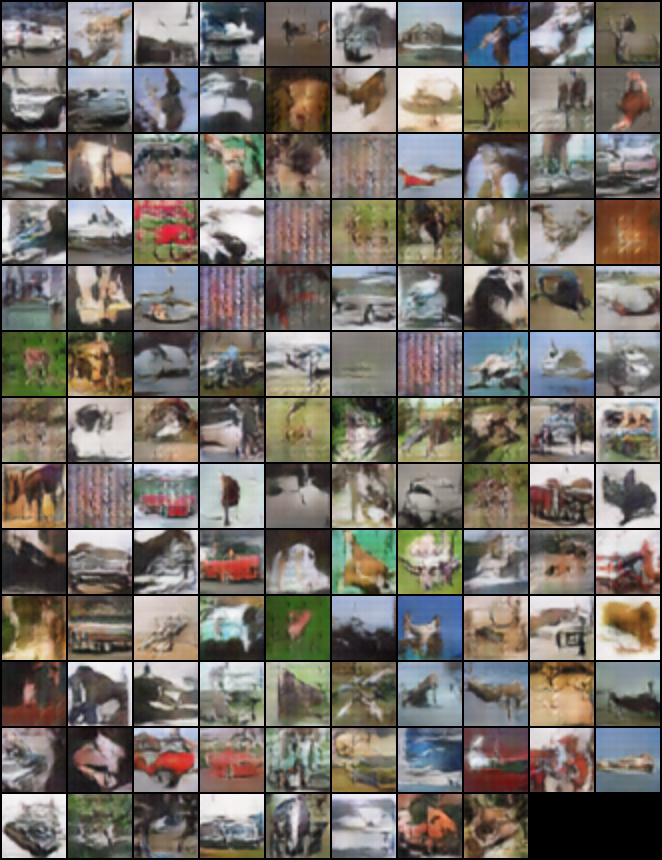

In [65]:
# обычный DCGAN
Image(os.path.join('images', 'fake_images-0300.png'))

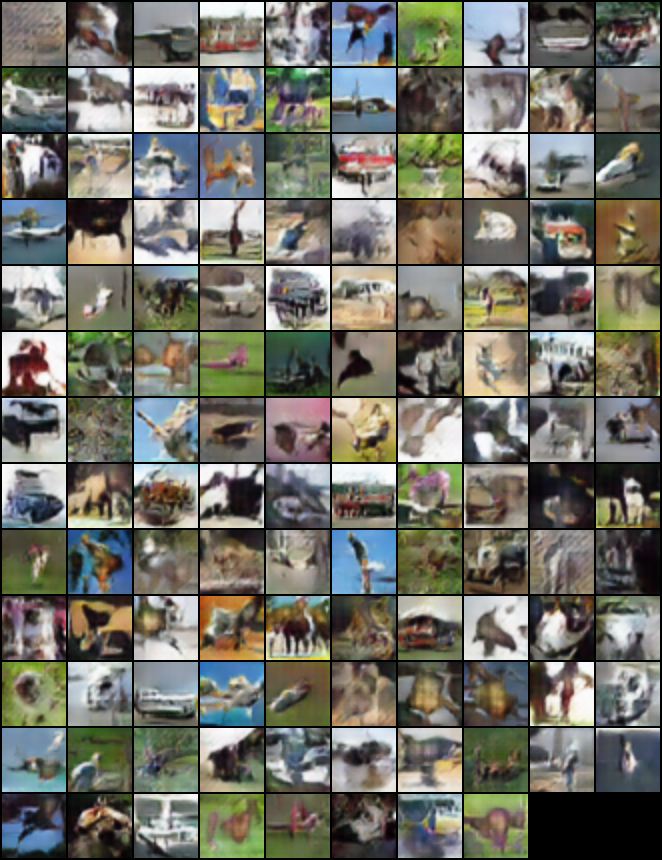

In [66]:
# спектральная нормализация
Image(os.path.join('images_sn', 'fake_images-0300.png'))

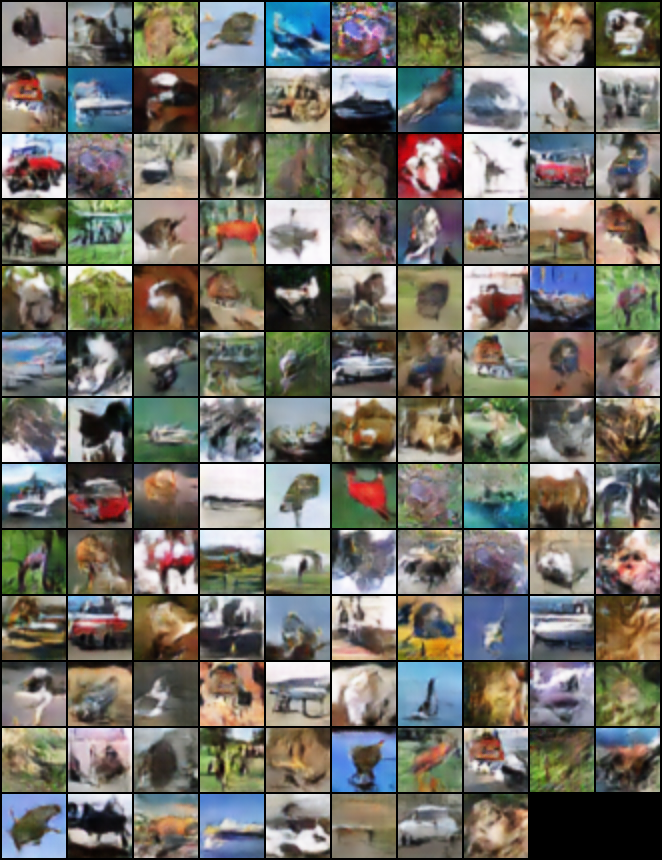

In [68]:
# спектральная нормализация и label smoothing
Image(os.path.join('images_sn_ls', 'fake_images-0300.png'))

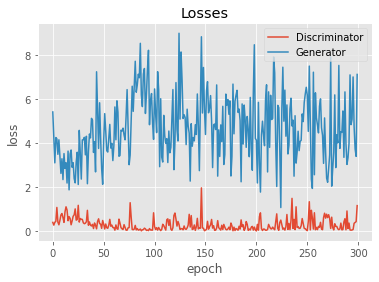

In [23]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

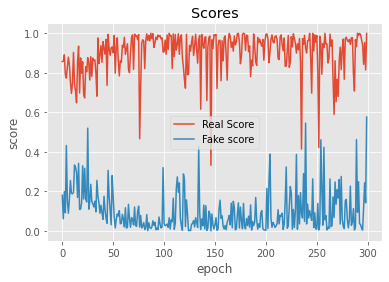

In [24]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [26]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

Cloning into 'pytorch-gan-metrics'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 241 (delta 2), reused 2 (delta 0), pack-reused 230
Receiving objects: 100% (241/241), 61.51 KiB | 473.00 KiB/s, done.
Resolving deltas: 100% (135/135), done.


In [71]:
 # import function from pytorch_gan_metrics 
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)
from torch.utils.data import Dataset

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, index):
        return denorm(self.G(torch.randn(1, self.z_dim, 1, 1).to(device))[0])

# define dataset
gen_dataset = GeneratorDataset(G, CFG.nz)

#create dataloader
gen_dataloader = DataLoader(gen_dataset, batch_size=2)

# Inception Score
# Frechet Inception Distance
# Inception Score + Frechet Inception Distance


In [ ]:
def metric(weights_pth: str):
    G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)
    weights = torch.load(weights_pth)
    G.load_state_dict(weights)
    gen_dataset = GeneratorDataset(G, CFG.nz)
    gen_dataloader = DataLoader(gen_dataset, batch_size=2)
    
    (incept_score, _), fid_score = get_inception_score_and_fid(gen_dataloader, fid_stats_path='fid_stats_cifar10_train.npz') 
    return incept_score, fid_score

In [72]:
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()
        # ConvTranspose2d nz ngf * 8
        # BatchNorm2d
        # ReLU
        self.block_1 = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )
        # ConvTranspose2d ngf * 8 ngf * 4
        # BatchNorm2d
        # ReLU
        self.block_2 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        )
        # ConvTranspose2d ngf * 4 ngf * 2
        # BatchNorm2d
        # ReLU
        self.block_3 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )
        # ConvTranspose2d ngf * 2 ngf  
        # BatchNorm2d
        # ReLU
        self.block_4 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )
        # ConvTranspose2d ngf  nc
        self.block_5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        
        # Tanh

    def forward(self, input_):
        x = self.block_1(input_)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        return F.tanh(x)

In [81]:
# обычный DCGAN
IS_1, FID_1 = metric('DCGAN_vanilla.pt')
IS_1, FID_1

(2.78900699180448, 151.87301683960663)

In [94]:
# DCGAN и добавлен label smoothing , спектральная нормализация
IS_final, FID_final = metric('DCGAN_final.pt')
IS_final, FID_final

(2.844278393223476, 162.2416026166748)

In [27]:
#

In [102]:
pd.DataFrame({"Models": ['DCGAN', 'Label Smoothing (LS)', 'Spectral Normalization (SN)', 'DCGAN + LS + SN'], "IS": [IS_1, IS_2, IS_3 IS_final],"FID": [FID_1, FID_2, FID_3, FID_final]})

Models        IS         FID
0                        DCGAN  2.789007  151.873017
1         Label Smoothing (LS)  2.531703  224.332684
2  Spectral Normalization (SN)  3.022998  154.085878
3              DCGAN + LS + SN  2.844278  162.241603